In [2]:
from linescanning import prf
import numpy as np
from scipy.stats import ttest_rel
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
from statsmodels.stats.weightstats import DescrStatsW
import random
from prfpy import stimulus
import yaml
from scipy import io
from copy import deepcopy
import matplotlib.patches as mpatches 
from matplotlib import gridspec

opd = os.path.dirname
opj = os.path.join

%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white' 

## <h1> Analysis of the effect of memantine on V1 pRF characteristics </h1>
This notebook is used to calculate the effect of memantine on neuronal responses in V1, assessed using pRF modeling with the divisive normalization (DN) model. It consists of several parts. The first part involves the calculation of the effect of memantine on the linearized pRF profile P(x) at different eccentricities. The second part involves assessing the effect of memantine on the temporal response to a bar sweep, both in measured BOLD response and predicted model response. The third part involves testing differences in nonlinear spatial summation using response profile r(s). The last part involves testing individual (and derivative) DN model parameters to assess the effect of memantine on individal model parameters.

In [4]:
# First, load necessary settings for pRF analysis

with open('/data1/projects/Meman1/projects/pilot/code/kelcey/github/fitting/prf_analysis.yml') as f:
    analysis_info = yaml.safe_load(f)

dm = io.loadmat(opj('/data1/projects/Meman1/projects/pilot/code', 'design_task-2R.mat'))['stim']

# define the pRF stimulus
prf_stim = stimulus.PRFStimulus2D(
    screen_size_cm=analysis_info['screen_size_cm'],
    screen_distance_cm=analysis_info['screen_distance_cm'],
    design_matrix=dm[:,:,5:40],
    TR=analysis_info['TR'])

prf_stim2 = stimulus.PRFStimulus2D(
    screen_size_cm=analysis_info['screen_size_cm'],
    screen_distance_cm=analysis_info['screen_distance_cm'],
    design_matrix=dm[:,:,5:],
    TR=analysis_info['TR'])

ss = prf_stim.screen_size_degrees
max_ecc_size = ss/2.0

In [5]:
# Define bounds for fitting
norm_bounds = {
                'x': 'fixed',  # x
                'y': 'fixed',  # y
               'prf_size': (0.2, 1.5*ss),  # prf size
               'A': (0,1000),  # prf amplitude
               'C': tuple(analysis_info['norm']['surround_amplitude_bound']),  # surround amplitude
               'surr_size': (0.1, 3*ss),  # surround size
               'B': tuple(analysis_info['norm']['neural_baseline_bound']),  # neural baseline
               'D': (1, 1)# surround baseline
}

In [6]:
# Define randomization
conditions = {
    'sub-001': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-002': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-003': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-004': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-005': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-007': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-008': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-010': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-012': {'memantine': 'ses-2', 'placebo': 'ses-3'},
    'sub-013': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-015': {'placebo': 'ses-2', 'memantine': 'ses-3'},
    'sub-016': {'memantine': 'ses-2', 'placebo': 'ses-3'}
}

# All subs but with sub-015 excluded for group analyses
newsubs = ['sub-001','sub-002','sub-003','sub-004','sub-005','sub-007','sub-008','sub-010','sub-012','sub-013','sub-016']

minr2=0.1
minecc=0.5 #The minimum
maxecc=4.5 #The maximum eccentricity you want to use
deriv='/data1/projects/Meman1/projects/pilot/derivatives'
freesurf='/data1/projects/Meman1/projects/pilot/derivatives/freesurfer'
model='norm'

placebo_patch = mpatches.Patch(color='royalblue', label='placebo')
memantine_patch = mpatches.Patch(color='firebrick', label='memantine')

In [7]:
class Add_pRF_profile:
    # Class to do some filtering on a pRFmodelFitting object on Gaussian model. You mainly specify the eccentricities that you want to look at, your minimum r2, and potentially a ROI
    # It returns an object with most of the characteristics of the pRFmodelFitting, but also adds FWHM and FWMIN
    
    def __init__(self,
                 pRFmodelFitting=None,
                 data=None,
                 design=None,
                 model=None,
                 stage=None,
                 params=None,
                 roi=None,
                 excludenegampl=False,
                 normalizeprofile=False,
                 eccmask=[minecc, maxecc],
                 r2mask=minr2):
        
        self.pRFmodelFitting=pRFmodelFitting
        if isinstance(self.pRFmodelFitting, prf.pRFmodelFitting):
            # if pRFmodelFitting object, get the necessary settings from here
            self.data=self.pRFmodelFitting.data
            self.model=self.pRFmodelFitting.model
            self.stage=self.pRFmodelFitting.stage
            self.params=prf.Parameters(params=getattr(self.pRFmodelFitting, f"{self.model}_{self.stage}"), model=self.model).to_df()
            self.design=self.pRFmodelFitting.design_matrix

        else:
            # else, take from manual input
            self.data=data
            self.model=model
            self.stage=stage
            self.params=params
            self.design=design
            
        # some additional settings
        self.excludenegampl=excludenegampl
        self.normalizeprofile=normalizeprofile
        self.eccmask=eccmask
        self.r2mask=r2mask
        self.roi=roi

        # select vertices based on roi...
        if self.roi is not None:
            try:
                self.params=self.params.loc[self.roi]
                print("ROI has", len(self.roi), "values")
            except:
                print("Not a valid ROI, give an array with vertex numbers for the ROI")
                print(len(self.roi))
                
        # drop vertices based on eccentricity and r2 boundaries
        self.params.loc[self.params['ecc'].values < self.eccmask[0]] = np.nan
        self.params.loc[self.params['ecc'].values > self.eccmask[1]] = np.nan
        self.params.loc[self.params['r2'].values < self.r2mask] = np.nan

        # drop vertices based on biological plausibility
        self.params.loc[self.params['surr_size'].values < self.params['prf_size'].values] = np.nan
        self.params.loc[self.params['prf_size'].values < 1.01*norm_bounds['prf_size'][0]] = np.nan

        print("Excluding", self.params.isna().any(axis=1).sum(), 'vertices based on mask...')
        self.params=self.params.dropna()
        # drop vertices if they have a negative pRF amplitude
        if self.excludenegampl:
            self.params.loc[self.params['prf_ampl'].values < 0] = np.nan
            print("Excluding", self.params.isna().any(axis=1).sum(), 'negative pRFs...')
            self.params=self.params.dropna()
        
        self.params=self.params[~self.params.index.duplicated(keep='first')]

        if self.model=='norm':
            self.params['phi'] = self.params['surr_size'].values/self.params['prf_size'].values
        # initialize profile characteristics
        self.x = np.linspace(-10,10,2000).astype('float32')
        self.profile_df = pd.DataFrame(index=self.params.index, columns=self.x)

        # function to calculate profile, fwhm given an Add_pRF_profile object and a vertex index
        def profile_fwhm_fwmin(self, index):
            x = self.x
            params = self.params.loc[index]

            # calculate the activation pRF profile (and the volume underneath pRF)
            profile_act = params.prf_ampl * np.exp(-0.5*(x**2) / (params.prf_size**2))
            volume_act = np.sqrt(2*np.pi*(params.prf_size**2)) # NOT USED NOW, CAN BE USED LATER!!

            if self.model=='gauss':
                # calculate halfmax and fwhmax
                half_max = np.max(profile_act, axis=0)/2
                fwhmax = np.abs(2*x[np.argmin(np.abs(profile_act-half_max), axis=0)])

                return fwhmax, half_max
            
            elif self.model=='norm':
                # calculate the normalization pRF profule (and the volume underneath pRF)
                profile_norm = params.surr_ampl * np.exp(-0.5*(x**2) / (params.surr_size**2))
                volume_norm = np.sqrt(2*np.pi*(params.surr_size**2)) # NOT USED NOW, CAN BE USED LATER!!

                # calculate full profile based on constants, profile act, and profile norm
                profile = (profile_act + params.B)/(profile_norm + params.D) - (params.B/params.D)
                
                # normalize RFs if necessary
                if self.normalizeprofile:
                    profile /= np.max(profile)

                # calculate halfmax and fwhmax
                half_max = np.max(profile, axis=0)/2
                fwhmax = np.abs(2*x[np.argmin(np.abs(profile-half_max), axis=0)])

                minim = np.min(profile, axis=0)
                maxim = np.max(profile, axis=0)

                fwmin= np.abs(2*x[np.argmin(profile, axis=0)])                

                # if fwmin is this large, it does not make any sense really as there is no visible surround. leaving it in would create an outlier    
                if fwmin==float(20.0):
                    fwmin=np.nan
                
                if minim>0 or maxim<0.01 or profile[999]<maxim:
                    fwhmax=np.nan
                    half_max=np.nan
                    minim=np.nan
                    maxim=np.nan
                    fwmin=np.nan
                    
                return fwhmax, half_max, minim, maxim, fwmin

        # now, add the profile measures to the dataframe
        if self.model=='gauss':
            for vert in self.params.index:
                fwhmaxx, half_maxx = profile_fwhm_fwmin(self, vert)
                self.params.loc[vert, 'fwhm'] = fwhmaxx
                self.params.loc[vert, 'half_max'] = half_maxx

        elif self.model=='norm':
            for vert in self.params.index:
                fwhmaxx, half_maxx, minimm, maximm, fwminn = profile_fwhm_fwmin(self, vert)
                if abs(minimm)/maximm == np.inf:
                    print(vert)
                self.params.loc[vert, 'fwhm'] = fwhmaxx
                self.params.loc[vert, 'half_max'] = half_maxx
                self.params.loc[vert, 'minimum'] = minimm
                self.params.loc[vert, 'maximum'] = maximm
                self.params.loc[vert, 'min/max'] = minimm/maximm
                self.params.loc[vert, 'fwmin'] = fwminn
                self.params.loc[vert, 'basetopeak']= np.abs(maximm-minimm)

In [9]:
def get_descriptives(row, param, weighted=False):
    ## This is a function to quickly get descriptive metric for individual pRF parameters, weighted by the R2 of individual vertices
    
    totest = row.dropna(subset=param)

    if weighted:
        descriptives = DescrStatsW(totest[param], weights=totest['r2'])
        mean = descriptives.mean
        std = descriptives.std
        n = len(totest)
        sem = std/np.sqrt(n)
    else:
        mean = totest[param].mean()
        std = totest[param].std()
        n = len(totest)
        sem = std/np.sqrt(n)
    
    return mean, std, sem

In [12]:
def profile_fwhm_fwmin(params, normalizeprofile=False, model='norm'):
    ## This is a function to calculate the linearized pRF profile of individual vertices based on model parameters

    x = np.linspace(-10,10,2000)

    # calculate the activation pRF profile (and the volume underneath pRF)
    profile_act = params['A'] * np.exp(-0.5*(x**2) / (params['prf_size']**2))
    volume_act = np.sqrt(2*np.pi*(params['prf_size']**2)) # NOT USED NOW, CAN BE USED LATER!!

    if model=='gauss':
        return profile_act
            
    elif model=='norm':
        # calculate the normalization pRF profule (and the volume underneath pRF)
        profile_norm = params['C'] * np.exp(-0.5*(x**2) / (params['surr_size']**2))
        volume_norm = np.sqrt(2*np.pi*(params['surr_size']**2)) # NOT USED NOW, CAN BE USED LATER!!

        # calculate full profile based on constants, profile act, and profile norm
        profile = (profile_act + params['B'])/(profile_norm + params['D']) - (params['B']/params['D'])
                
        # normalize RFs if necessary
        if normalizeprofile:
            profile /= np.max(profile)

        # calculate halfmax and fwhmax
        half_max = np.max(profile, axis=0)/2
        fwhmax = np.abs(2*x[np.argmin(np.abs(profile-half_max), axis=0)])

        minim = np.min(profile, axis=0)
        maxim = np.max(profile, axis=0)

        fwmin= np.abs(2*x[np.argmin(profile, axis=0)])                

        # if the profile has these weird characteristics    
        if fwmin==float(20.0) or minim>0 or maxim<0.01 or profile[999]<maxim:
            profile = np.empty((0,2000))
        
        return profile

In [13]:
def get_mean_profile(profilearray, weighted=False, weights=None):
    ## This is a function to calculate descriptive metrics of an array of pRF responses for different vertices, potentially weighted by R2 
    
    if weighted:
        mean_profile = DescrStatsW(profilearray, weights=weights)
        mean = mean_profile.mean
        std = mean_profile.std
        n = profilearray.shape[0]
        sem = std/np.sqrt(n)
        ci = 1.96*sem

    else:
        mean = profilearray.mean(axis=0)
        std = profilearray.std(axis=0)
        n = profilearray.shape[0]
        sem = std/np.sqrt(n)
        ci = 1.96*sem
    
    return mean, std, sem, ci

In [14]:
# SAY HERE IF YOU WANT ANALYSIS TO BE WEIGHTED BY R2 OR NOT
weighted = True

In [15]:
def weighted_median(values, weights):
    # Convert to numpy arrays
    values = np.array(values)
    weights = np.array(weights)

    if len(values) == 0:
        raise ValueError("Values array is empty")

    if np.all(weights == 0):
        raise ValueError("All weights are zero")

    # Sort values and weights by the values
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    sorted_weights = weights[sorted_indices]

    # Compute the cumulative weight sum
    cumulative_weights = np.cumsum(sorted_weights)
    half_weight_sum = cumulative_weights[-1] / 2

    # Find the index where the cumulative weight reaches or exceeds half the total weight
    median_idx = np.searchsorted(cumulative_weights, half_weight_sum)

    # Handle the case where the cumulative weight is exactly half
    if cumulative_weights[median_idx] == half_weight_sum and median_idx + 1 < len(sorted_values):
        return (sorted_values[median_idx] + sorted_values[median_idx + 1]) / 2

    return sorted_values[median_idx]


In [109]:
# necessary to calculate predicted time course

from prfpy.model import Model
xx = Model(prf_stim)

<h2>0. Extracting DN model parameters for all subjects in both conditions </h2>

In [8]:
# Initialize dictionary with fits and ROI vertices per subject
prffits = {
    sub: {
        'fits': {'placebo': None, 'memantine': None},
        'roi_vertices': {'V1_vertices': None, 'V2_vertices': None, 'V3_vertices': None, 'hV4_vertices': None, 'VO_vertices': None, 'V3AB_vertices': None, 'LO_vertices': None, 'hMT_vertices': None, 'PIPS_vertices': None, 'IAIPS_vertices':None, 'SAIPS_vertices': None, 'FEF_vertices': None}
    } for sub in conditions.keys()}

In [ ]:
for sub in conditions.keys():
    print(f"Working on subject {sub}...")
    print("")


    #######################################################
    ###### LOADING IN ROIs ################
    #######################################################

    print("Getting ROI vertices...")
    print("")

    finalrois= opj(deriv, 'freesurfer',sub, 'customlabel', 'roidrawing', 'final')
    
    #Load vertices from left hemisphere, together with the number of vertices in the left hemisphere so indexing for right hemisphere works appropriately; the .label files start from 0 and work per hemisphere, whereas Inkscape merges the two hemispheres together.
    V1_lh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'lh.V1.label'))
    V2_lh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'lh.V2.label'))
    V3_lh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'lh.V3.label'))
    hV4_lh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'lh.hV4.label'))
    VO_lh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'lh.VO-cluster.label'))
    V3AB_lh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'lh.V3AB.label'))
    LO_lh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'lh.LO-cluster.label'))
    hMT_lh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'lh.hMT+.label'))
    PIPS_lh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'lh.P-IPS.label'))
    SAIPS_lh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'lh.SA-IPS.label'))
    IAIPS_lh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'lh.IA-IPS.label'))
    FEF_lh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'lh.FEF.label'))
    all_lh = nib.freesurfer.read_geometry(opj(deriv, 'freesurfer', sub, 'surf', 'lh.inflated'))

    #Load vertices from right hemisphere. 
    V1_rh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'rh.V1.label'))
    V2_rh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'rh.V2.label'))
    V3_rh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'rh.V3.label'))
    hV4_rh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'rh.hV4.label'))
    VO_rh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'rh.VO-cluster.label'))
    V3AB_rh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'rh.V3AB.label'))
    LO_rh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'rh.LO-cluster.label'))
    hMT_rh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'rh.hMT+.label'))
    PIPS_rh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'rh.P-IPS.label'))
    SAIPS_rh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'rh.SA-IPS.label'))
    IAIPS_rh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'rh.IA-IPS.label'))
    FEF_rh = nib.freesurfer.read_label(opj(freesurf, sub, 'customlabel','roidrawing', 'higherorder',  'corrections', 'rh.FEF.label'))

    all_rh = nib.freesurfer.read_geometry(opj(deriv, 'freesurfer', sub, 'surf', 'rh.inflated'))

    # Get the right indices for the right hemisphere by adding the number of vertices in left hemisphere to the ROI indices for the right hemisphere.
    V1_rh = V1_rh + len(all_lh[0])
    V2_rh = V2_rh + len(all_lh[0])
    V3_rh = V3_rh + len(all_lh[0])
    hV4_rh = hV4_rh + len(all_lh[0])
    VO_rh = VO_rh + len(all_lh[0])
    V3AB_rh = V3AB_rh + len(all_lh[0])
    LO_rh = LO_rh + len(all_lh[0])
    hMT_rh = hMT_rh + len(all_lh[0])
    PIPS_rh = PIPS_rh + len(all_lh[0])
    SAIPS_rh = SAIPS_rh + len(all_lh[0])
    IAIPS_rh = IAIPS_rh + len(all_lh[0])
    FEF_rh = FEF_rh + len(all_lh[0])


    # Concatenate the 2 and sort them such that they are in the right order
    V1_vertices = np.sort(np.concatenate([V1_lh, V1_rh]))
    V2_vertices = np.sort(np.concatenate([V2_lh, V2_rh]))
    V3_vertices = np.sort(np.concatenate([V3_lh, V3_rh]))
    hV4_vertices = np.sort(np.concatenate([hV4_lh, hV4_rh]))
    VO_vertices = np.sort(np.concatenate([VO_lh, VO_rh]))
    V3AB_vertices = np.sort(np.concatenate([V3AB_lh, V3AB_rh]))
    LO_vertices = np.sort(np.concatenate([LO_lh, LO_rh]))
    hMT_vertices = np.sort(np.concatenate([hMT_lh, hMT_rh]))
    PIPS_vertices = np.sort(np.concatenate([PIPS_lh, PIPS_rh]))
    SAIPS_vertices = np.sort(np.concatenate([SAIPS_lh, SAIPS_rh]))
    IAIPS_vertices = np.sort(np.concatenate([IAIPS_lh, IAIPS_rh]))
    FEF_vertices = np.sort(np.concatenate([FEF_lh, FEF_rh]))

    roi_vertices = np.sort(np.concatenate([V1_vertices, V2_vertices, V3_vertices, hV4_vertices, VO_vertices, V3AB_vertices, LO_vertices, hMT_vertices, PIPS_vertices, SAIPS_vertices, IAIPS_vertices, FEF_vertices]))


    prffits[sub]['roi_vertices']['V1_vertices'] = V1_vertices
    prffits[sub]['roi_vertices']['V2_vertices'] = V2_vertices
    prffits[sub]['roi_vertices']['V3_vertices'] = V3_vertices
    prffits[sub]['roi_vertices']['hV4_vertices'] = hV4_vertices
    prffits[sub]['roi_vertices']['VO_vertices'] = VO_vertices
    prffits[sub]['roi_vertices']['V3AB_vertices'] = V3AB_vertices
    prffits[sub]['roi_vertices']['LO_vertices'] = LO_vertices
    prffits[sub]['roi_vertices']['hMT_vertices'] = hMT_vertices
    prffits[sub]['roi_vertices']['PIPS_vertices'] = PIPS_vertices
    prffits[sub]['roi_vertices']['SAIPS_vertices'] = SAIPS_vertices
    prffits[sub]['roi_vertices']['IAIPS_vertices'] = IAIPS_vertices
    prffits[sub]['roi_vertices']['FEF_vertices'] = FEF_vertices
    
    for condition in ['placebo', 'memantine']:
        print(f"Working on {condition}...")
        print("")

        # First, get path to the appropriate files
        design = prf.read_par_file(opj(deriv, 'prf', sub, 'design_task-2R.mat'))
        outputdata = opj('/data1/projects/Meman1/projects/pilot/code/kelcey/snellius/finaloutput', sub)

        # Load data
        data = np.load(opj(deriv, 'prf', sub, conditions[sub][condition], f'{sub}_{conditions[sub][condition]}_task-2R_hemi-LR_desc-avg_bold.npy'))

        # Initialize empty array of parameters with the appropriate shape
        params_norm = np.zeros(shape=(data.shape[1], 12))

        #######################################################
        ###### GETTING ALL PARAMETERS IN RIGHT SPOT ###########
        #######################################################

        print("Putting parameters in right place...")
        print("")

        for i in range(20):
            roivertices_file = opj(outputdata, 'roivertices', f'roivertices_{sub}_slice-{i}.npy')
            paramss_file = opj(outputdata, 'fits', f'{sub}_{conditions[sub][condition]}_task-2R_model-norm_stage-iter_desc-prfparams_slice-{i}.npy')
         #   print(f"checking for files:\n - {roivertices_file}\n - {paramss_file}")
            if os.path.isfile(roivertices_file) and os.path.isfile(paramss_file):
                roivertices = np.load(roivertices_file)
                paramss = np.load(paramss_file)

                for index, roivertex in enumerate(roivertices):
                    params_norm[roivertex] = paramss[index]

            else:  
                if not os.path.isfile(roivertices_file):
                    print(f"File {roivertices_file} for slice {i} missing, skipping..")
                    print("")
                if not os.path.isfile(paramss_file):
                    print(f"File {paramss_file} for slice {i} missing, skipping..")
                    print("")
        #######################################################
        ###### LOADING IN PARAMETERS IN OBJECT ################
        #######################################################
        print("Creating pRFmodelFitting object...")
        print("")
        
        # initialize empty model
        norm_obj= prf.pRFmodelFitting(
            data.T,
            design_matrix=design,
            TR=1.5,                     # default
            model=model,                # default, can be 'gauss', 'css', 'dog', 'norm'
            stage="iter",               # default
            verbose=True,               # keep track of what we're doing,
            fix_bold_baseline=True      # fix the BOLD baseline at 0
        )

        # load params
        norm_obj.load_params(params_norm, model=model, stage="iter")

        #######################################################
        ###### CREATING AN ADD_PRF_PROFILE OBJ ################
        #######################################################
        print("Creating an Add_pRF_profile...")
        print("")

        norm_filtered = Add_pRF_profile(norm_obj, r2mask=0.1, eccmask=[0.5, 4.5], roi=roi_vertices) # You can change things here in the settings if you want

        #######################################################
        ###### ADDING TO DICTIONARY NOW     ###################
        #######################################################

        prffits[sub]['fits'][condition] = norm_filtered

Working on subject sub-001...

Getting ROI vertices...

Working on placebo...

Putting parameters in right place...

Creating pRFmodelFitting object...

Design has 5 more volumes than timecourses, trimming from beginning of design to (100, 100, 220)
Reading settings from '/data1/projects/Meman1/projects/pilot/code/prf_analysis.yml'

---------------------------------------------------------------------------------------------------
Check these important settings!
 Screen distance: 196cm
 Screen size: 39.3cm
 TR: 1.5s
---------------------------------------------------------------------------------------------------

Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0] (fit=True)
Using constraint(s): ['tc', 'tc']
Inserting parameters from <class 'numpy.ndarray'> as 'norm_iter' in <linescanning.prf.pRFmodelFitting object at 0x7f66c0147430>
Creating an Add_pRF_profile...

ROI has 25074 values
Excluding 15965 vertices based on mask...
Working on memantine...

Putting parameters in righ

<h2> 1. Calculate effect of eccentricity on relative minimum of pRF profile </h2>

In [ ]:
# Characteristics of eccentricity bins, computed by median ## 
normalize_profiles = True
num_bins=10
bin_edges = np.linspace(0.5,4.5, num_bins+1)
metric = 'min/max'

# Calculate the necessary metrics for all the subjects and saving them

meandict = {
    sub: {
        condition: {
            'scatter': {},
            'profile': {'mean': {}, 'ci': {}},
            'profile_absolute': {'mean': {}, 'ci': {}},
            'bar': {}
        } for condition in ['placebo', 'memantine']
    } | {'difference': {}}
    for sub in conditions.keys()}



# Plot 1: Metric versus Eccentricity in both conditions

for index, sub in enumerate(conditions.keys()):

    if sub == 'sub-015':
        print('sub-015 has invalid vertices in 0.5-1.0 eccentricity')
        continue
    print(f'working on {sub}')
    valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    # only select vertices that had r2>0.3 for at least one of the conditions
    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>0.3 and 
                                prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>0.3)]
   

    ############## 1. CALCULATE DIFFERENCES #####################
    filtered_params_plac = prffits[sub]['fits']['placebo'].params.loc[valid_vertices_V1_shared]
    filtered_params_mem = prffits[sub]['fits']['memantine'].params.loc[valid_vertices_V1_shared]
    
    # Create new dataframe with differences
    diff_df = pd.DataFrame(columns=['vertex_nr', f'{metric} diff', 'mean_ecc','mean_r2'])
    diff_df['vertex_nr'] = valid_vertices_V1_shared
    diff_df[f'{metric} diff'] = filtered_params_plac[metric].values-filtered_params_mem[metric].values



    for param in ['ecc','r2']:
        diff_df[f'mean_{param}'] = np.median([filtered_params_plac[param], filtered_params_mem[param]], axis=0)



    # Now, calculate the difference while grouped in eccentricity bins
    shapemetrics_V1 = diff_df.dropna(subset=f'{metric} diff')

      # Calculate the bin edges based on the combined data
    all_ecc_values = pd.concat([prffits[sub]['fits']['placebo'].params.loc[valid_vertices_V1_shared]['ecc'],
                        prffits[sub]['fits']['memantine'].params.loc[valid_vertices_V1_shared]['ecc']])
    
    ecc_bin_edges = pd.cut(all_ecc_values, bins=num_bins, retbins=True, labels=False, include_lowest=True)[1]
    ecc_bin_edges[0] = ecc_bin_edges[0] - 1e-6  # Shift lower bound slightly to include extreme values
    ecc_bin_edges[-1] = ecc_bin_edges[-1] + 1e-6

    # Calculate eccentricity bins for each ROI
    shapemetrics_V1['eccentricity_bin'] = pd.cut(shapemetrics_V1['mean_ecc'], bins=ecc_bin_edges, labels=range(num_bins), include_lowest=False)



    # Calculate median for each group
    df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x['mean_ecc'], weights=x['mean_r2']))
    df_mean_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x[f'{metric} diff'], weights=x['mean_r2']))
    

    # Put in the dictionary
    meandict[sub]['difference']['mean_ecc'] = df_mean_ecc_v1
    meandict[sub]['difference']['mean_metric'] = df_mean_metric_v1


  
    for index, condition in enumerate(['placebo', 'memantine']):

        

        ############## 2. CALCULATE ECCENTRICITY VS METRIC PER CONDITION  ###################

        shapemetrics_V1 = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared].dropna(subset=metric)



       # shapemetrics_V1['eccentricity_bin'] = pd.qcut(shapemetrics_V1['ecc'], q=num_bins, labels=range(10))
        shapemetrics_V1['eccentricity_bin'] = pd.cut(shapemetrics_V1['ecc'], bins = ecc_bin_edges, labels=range(num_bins), include_lowest=False)

        # Calculate mean for each group

        df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x['ecc'], weights=x['r2']))
        df_mean_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x[metric], weights=x['r2']))
        df_sem_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: np.std(x[metric]) / np.sqrt(len(x[metric])))

        meandict[sub][condition]['scatter']['mean_ecc'] = df_mean_ecc_v1
        meandict[sub][condition]['scatter']['mean_metric'] = df_mean_metric_v1
        meandict[sub][condition]['scatter']['sem_metric'] = df_sem_metric_v1



        ############## 3. CALCULATE MEAN OF GROUP IN DIFFERENT ECCENTRICITIES ###################

        for ecc_range in [(0.5,1.0), (1.0,1.5), (1.5,2.0), (2.0,2.5), (2.5,3.0), (3.0,4.5), (0.5,0.75), (0.5,2.5), (2.5,4.5), (0.5,4.5)]:
            filtered_params_ecc = shapemetrics_V1.loc[(shapemetrics_V1['ecc']>ecc_range[0]) & (shapemetrics_V1['ecc']<ecc_range[1])]
            mean_metric,_,_ = get_descriptives(filtered_params_ecc, 'min/max',weighted=True)
            meandict[sub][condition]['bar'][f'{ecc_range[0]}-{ecc_range[1]}'] = mean_metric     

        ############## 4. CALCULATE PROFILE PER CONDITION  ################### --> THIS CAN BE PUT IN THE OTHER LOOP

        shapemetrics_1 = shapemetrics_V1[shapemetrics_V1['ecc'] < 1.0]
        shapemetrics_2 = shapemetrics_V1[(shapemetrics_V1['ecc'] > 1.0) & (shapemetrics_V1['ecc'] < 1.5)]
        shapemetrics_3 = shapemetrics_V1[(shapemetrics_V1['ecc'] > 1.5) & (shapemetrics_V1['ecc'] < 2.0)]
        shapemetrics_4 = shapemetrics_V1[(shapemetrics_V1['ecc'] > 2.0) & (shapemetrics_V1['ecc'] < 2.5)]
        shapemetrics_5 = shapemetrics_V1[(shapemetrics_V1['ecc'] > 2.5) & (shapemetrics_V1['ecc'] < 3.0)]
        shapemetrics_high = shapemetrics_V1[shapemetrics_V1['ecc'] > 3.0]
        shapemetrics_reversed = shapemetrics_V1[(shapemetrics_V1['ecc'] >= 0.5) & (shapemetrics_V1['ecc'] <= 0.75)]
        shapemetrics_low = shapemetrics_V1[(shapemetrics_V1['ecc'] >= 0.5) & (shapemetrics_V1['ecc'] <= 2.5)]
        shapemetrics_all = shapemetrics_V1[(shapemetrics_V1['ecc'] >= 2.5) & (shapemetrics_V1['ecc'] <= 4.5)]
        shapemetrics_allecc = shapemetrics_V1[(shapemetrics_V1['ecc'] >= 0.5) & (shapemetrics_V1['ecc'] <= 4.5)]
        shapemetrics_smallrange = shapemetrics_V1[(shapemetrics_V1['ecc'] >= 0.5) & (shapemetrics_V1['ecc'] <= 1.5)]

        allprofiles_1 = {'vertex': [],'r2': [],'profile': []}
        allprofiles_2 = {'vertex': [],'r2': [],'profile': []}
        allprofiles_3 = {'vertex': [],'r2': [],'profile': []}
        allprofiles_4 = {'vertex': [],'r2': [],'profile': []}
        allprofiles_5 = {'vertex': [],'r2': [],'profile': []}
        allprofiles_high = {'vertex': [],'r2': [],'profile': []}
        allprofiles_reversed = {'vertex': [],'r2': [],'profile': []}
        allprofiles_low = {'vertex': [],'r2': [],'profile': [], 'profile_absolute': []}
        allprofiles_all = {'vertex': [],'r2': [],'profile': [], 'profile_absolute': []}
        allprofiles_allecc = {'vertex': [],'r2': [],'profile': [], 'profile_absolute': []}
        allprofiles_smallrange = {'vertex': [],'r2': [],'profile': [], 'profile_absolute': []}

        for row in shapemetrics_1.iterrows():
            profile = profile_fwhm_fwmin(row[1],normalizeprofile=normalize_profiles)

            if profile.size != 0:
                allprofiles_1['vertex'].append(row[0])
                allprofiles_1['r2'].append(shapemetrics_1.loc[row[0]]['r2'])
                allprofiles_1['profile'].append(profile)



        for row in shapemetrics_2.iterrows():
            profile = profile_fwhm_fwmin(row[1],normalizeprofile=normalize_profiles)
            
            if profile.size != 0:
                allprofiles_2['vertex'].append(row[0])
                allprofiles_2['r2'].append(shapemetrics_2.loc[row[0]]['r2'])
                allprofiles_2['profile'].append(profile)

        for row in shapemetrics_3.iterrows():

            profile = profile_fwhm_fwmin(row[1],normalizeprofile=normalize_profiles)

            if profile.size != 0:
                allprofiles_3['vertex'].append(row[0])
                allprofiles_3['r2'].append(shapemetrics_3.loc[row[0]]['r2'])
                allprofiles_3['profile'].append(profile)



        for row in shapemetrics_4.iterrows():
            profile = profile_fwhm_fwmin(row[1],normalizeprofile=normalize_profiles)


            if profile.size != 0:
                allprofiles_4['vertex'].append(row[0])
                allprofiles_4['r2'].append(shapemetrics_4.loc[row[0]]['r2'])
                allprofiles_4['profile'].append(profile)
                


        for row in shapemetrics_5.iterrows():
            profile = profile_fwhm_fwmin(row[1],normalizeprofile=normalize_profiles)
            

            if profile.size != 0:
                allprofiles_5['vertex'].append(row[0])
                allprofiles_5['r2'].append(shapemetrics_5.loc[row[0]]['r2'])
                allprofiles_5['profile'].append(profile)


        for row in shapemetrics_high.iterrows():
            profile = profile_fwhm_fwmin(row[1],normalizeprofile=normalize_profiles)

            if profile.size != 0:
                allprofiles_high['vertex'].append(row[0])
                allprofiles_high['r2'].append(shapemetrics_high.loc[row[0]]['r2'])
                allprofiles_high['profile'].append(profile)

        

        for row in shapemetrics_reversed.iterrows():
            profile = profile_fwhm_fwmin(row[1],normalizeprofile=normalize_profiles)

            if profile.size != 0:

                allprofiles_reversed['vertex'].append(row[0])
                allprofiles_reversed['r2'].append(shapemetrics_reversed.loc[row[0]]['r2'])
                allprofiles_reversed['profile'].append(profile)

        for row in shapemetrics_low.iterrows():
            profile = profile_fwhm_fwmin(row[1],normalizeprofile=normalize_profiles)
            profile_absolute = profile_fwhm_fwmin(row[1],normalizeprofile=False)
            if profile.size != 0:

                allprofiles_low['vertex'].append(row[0])
                allprofiles_low['r2'].append(shapemetrics_low.loc[row[0]]['r2'])
                allprofiles_low['profile'].append(profile)
                allprofiles_low['profile_absolute'].append(profile_absolute)

        for row in shapemetrics_all.iterrows():
            profile = profile_fwhm_fwmin(row[1],normalizeprofile=normalize_profiles)
            profile_absolute = profile_fwhm_fwmin(row[1],normalizeprofile=False)
            if profile.size != 0:

                allprofiles_all['vertex'].append(row[0])
                allprofiles_all['r2'].append(shapemetrics_all.loc[row[0]]['r2'])
                allprofiles_all['profile'].append(profile)
                allprofiles_all['profile_absolute'].append(profile_absolute)

        for row in shapemetrics_allecc.iterrows():
            profile = profile_fwhm_fwmin(row[1],normalizeprofile=normalize_profiles)
            profile_absolute = profile_fwhm_fwmin(row[1],normalizeprofile=False)
            if profile.size != 0:

                allprofiles_allecc['vertex'].append(row[0])
                allprofiles_allecc['r2'].append(shapemetrics_allecc.loc[row[0]]['r2'])
                allprofiles_allecc['profile'].append(profile)
                allprofiles_allecc['profile_absolute'].append(profile_absolute)

        for row in shapemetrics_smallrange.iterrows():
            profile = profile_fwhm_fwmin(row[1],normalizeprofile=normalize_profiles)
            profile_absolute = profile_fwhm_fwmin(row[1],normalizeprofile=False)
            if profile.size != 0:

                allprofiles_smallrange['vertex'].append(row[0])
                allprofiles_smallrange['r2'].append(shapemetrics_smallrange.loc[row[0]]['r2'])
                allprofiles_smallrange['profile'].append(profile)
                allprofiles_smallrange['profile_absolute'].append(profile_absolute)
                
        # Calculate mean

        mean_1,_,_,ci_1 = get_mean_profile(np.vstack(allprofiles_1['profile']), weighted=True, weights=allprofiles_1['r2'])
        mean_2,_,_,ci_2 = get_mean_profile(np.vstack(allprofiles_2['profile']), weighted=True, weights=allprofiles_2['r2'])
        mean_3,_,_,ci_3 = get_mean_profile(np.vstack(allprofiles_3['profile']), weighted=True, weights=allprofiles_3['r2'])
        mean_4,_,_,ci_4 = get_mean_profile(np.vstack(allprofiles_4['profile']), weighted=True, weights=allprofiles_4['r2'])
        mean_low_absolute,_,_,ci_low_absolute = get_mean_profile(np.vstack(allprofiles_low['profile_absolute']), weighted=True, weights=allprofiles_low['r2'])
        mean_5,_,_,ci_5 = get_mean_profile(np.vstack(allprofiles_5['profile']), weighted=True, weights=allprofiles_5['r2'])
        mean_all_absolute,_,_,ci_all_absolute = get_mean_profile(np.vstack(allprofiles_all['profile_absolute']), weighted=True, weights=allprofiles_all['r2'])
        mean_high,_,_,ci_high = get_mean_profile(np.vstack(allprofiles_high['profile']), weighted=True, weights=allprofiles_high['r2'])
        mean_reversed,_,_,ci_reversed = get_mean_profile(np.vstack(allprofiles_reversed['profile']), weighted=True, weights=allprofiles_reversed['r2'])
        mean_low,_,_,ci_low = get_mean_profile(np.vstack(allprofiles_low['profile']), weighted=True, weights=allprofiles_low['r2'])
        mean_all,_,_,ci_all = get_mean_profile(np.vstack(allprofiles_all['profile']), weighted=True, weights=allprofiles_all['r2'])
        mean_allecc,_,_,ci_allecc = get_mean_profile(np.vstack(allprofiles_allecc['profile']), weighted=True, weights=allprofiles_allecc['r2'])
        mean_allecc_absolute,_,_,ci_allecc_absolute = get_mean_profile(np.vstack(allprofiles_allecc['profile_absolute']), weighted=True, weights=allprofiles_allecc['r2'])
        mean_smallrange,_,_,ci_smallrange = get_mean_profile(np.vstack(allprofiles_smallrange['profile']), weighted=True, weights=allprofiles_smallrange['r2'])
        mean_smallrange_absolute,_,_,ci_smallrange_absolute = get_mean_profile(np.vstack(allprofiles_smallrange['profile_absolute']), weighted=True, weights=allprofiles_smallrange['r2'])


        meandict[sub][condition]['profile']['mean']['0.5-1.0'] = mean_1
        meandict[sub][condition]['profile']['ci']['0.5-1.0'] = ci_1

        meandict[sub][condition]['profile']['mean']['1.0-1.5'] = mean_2
        meandict[sub][condition]['profile']['ci']['1.0-1.5'] = ci_2

        meandict[sub][condition]['profile']['mean']['1.5-2.0'] = mean_3
        meandict[sub][condition]['profile']['ci']['1.5-2.0'] = ci_3

        meandict[sub][condition]['profile']['mean']['2.0-2.5'] = mean_4
        meandict[sub][condition]['profile']['ci']['2.5-2.5'] = ci_4

        meandict[sub][condition]['profile_absolute']['mean']['0.5-2.5'] = mean_low_absolute
        meandict[sub][condition]['profile_absolute']['ci']['0.5-2.5'] = ci_low_absolute

        meandict[sub][condition]['profile']['mean']['2.5-3.0'] = mean_5
        meandict[sub][condition]['profile']['ci']['2.5-3.0'] = ci_5

        meandict[sub][condition]['profile_absolute']['mean']['2.5-4.5'] = mean_all_absolute
        meandict[sub][condition]['profile_absolute']['ci']['2.5-4.5'] = ci_all_absolute
        
        meandict[sub][condition]['profile']['mean']['3.0-4.5'] = mean_high
        meandict[sub][condition]['profile']['ci']['3.0-4.5'] = ci_high

        meandict[sub][condition]['profile']['mean']['0.5-0.75'] = mean_reversed
        meandict[sub][condition]['profile']['ci']['0.5-0.75'] = ci_reversed

        meandict[sub][condition]['profile']['mean']['0.5-2.5'] = mean_low
        meandict[sub][condition]['profile']['ci']['0.5-2.5'] = ci_low

        meandict[sub][condition]['profile']['mean']['2.5-4.5'] = mean_all
        meandict[sub][condition]['profile']['ci']['2.5-4.5'] = ci_all

        meandict[sub][condition]['profile']['mean']['0.5-4.5'] = mean_allecc
        meandict[sub][condition]['profile']['ci']['0.5-4.5'] = ci_allecc

        meandict[sub][condition]['profile_absolute']['mean']['0.5-4.5'] = mean_allecc_absolute
        meandict[sub][condition]['profile_absolute']['ci']['0.5-4.5'] = ci_allecc_absolute

        meandict[sub][condition]['profile']['mean']['0.5-1.5'] = mean_smallrange
        meandict[sub][condition]['profile']['ci']['0.5-1.5'] = ci_smallrange

        meandict[sub][condition]['profile_absolute']['mean']['0.5-1.5'] = mean_smallrange_absolute
        meandict[sub][condition]['profile_absolute']['ci']['0.5-1.5'] = ci_smallrange_absolute


Now, create a plot

Now, test statistically:

In [37]:
dfs = []

for sub in newsubs:
    print("Working on", sub)
    
    valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>0.3 and 
                                prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>0.3)]
    
    for condition in ['placebo','memantine']:
        filtered_params = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared]
        
        for ecc_range in [(0.5,1.0), (1.0,1.5), (1.5,2.0), (2.0,2.5), (2.5,3.0), (3.0,4.5)]:
        #for ecc_range in [(0.5,2.5), (2.5,4.5)]:                      
            filtered_params_ecc = filtered_params.loc[(filtered_params['ecc']>ecc_range[0]) & (filtered_params['ecc']<ecc_range[1])]
            
            mean_metric,_,_ = get_descriptives(filtered_params_ecc, 'min/max',weighted=True)

            data = {'sub':sub,
                    'condition':condition,
                    'eccentricity':f'{str(ecc_range[0])}-{str(ecc_range[1])}', 
                    'minmax': mean_metric}
            
            dfs.append(data)
            
mean_metric_df = pd.DataFrame(dfs)

Working on sub-001
Working on sub-002
Working on sub-003
Working on sub-004
Working on sub-005
Working on sub-007
Working on sub-008
Working on sub-010
Working on sub-012
Working on sub-013
Working on sub-016


In [21]:
dfs = []

for sub in newsubs:
    print("Working on", sub)
    
    valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2'] > 0.3 and 
                                 prffits[sub]['fits']['memantine'].params.loc[vertex]['r2'] > 0.3)]
    
    for condition in ['placebo', 'memantine']:
        filtered_params = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared]

        # Loop through pairs of consecutive bin edges
        for i in range(len(ecc_bin_edges) - 1):
            ecc_range = (ecc_bin_edges[i], ecc_bin_edges[i + 1])
            
            filtered_params_ecc = filtered_params.loc[(filtered_params['ecc'] > ecc_range[0]) & (filtered_params['ecc'] <= ecc_range[1])]
            
            mean_metric, _, _ = get_descriptives(filtered_params_ecc, 'min/max', weighted=True)

            data = {'sub': sub,
                    'condition': condition,
                    'eccentricity': f'{ecc_range[0]:.2f}-{ecc_range[1]:.2f}', 
                    'minmax': mean_metric}
            
            dfs.append(data)
            
mean_metric_df = pd.DataFrame(dfs)


Working on sub-001
Working on sub-002
Working on sub-003
Working on sub-004
Working on sub-005
Working on sub-007
Working on sub-008
Working on sub-010
Working on sub-012
Working on sub-013
Working on sub-016


In [22]:
mean_metric_df.head(10)

,sub,condition,eccentricity,minmax
0,sub-001,placebo,0.50-0.70,-0.038083
1,sub-001,placebo,0.70-0.90,-0.042626
2,sub-001,placebo,0.90-1.10,-0.039757
3,sub-001,placebo,1.10-1.30,-0.041654
4,sub-001,placebo,1.30-1.50,-0.057075
5,sub-001,placebo,1.50-1.70,-0.060677
6,sub-001,placebo,1.70-1.90,-0.061706
7,sub-001,placebo,1.90-2.10,-0.057839
8,sub-001,placebo,2.10-2.30,-0.069915
9,sub-001,placebo,2.30-2.50,-0.055785


Paired t-test based on eccentricity bins

In [39]:
eccentricities = ['0.5-1.0', '1.0-1.5', '1.5-2.0', '2.0-2.5', '2.5-3.0', '3.0-4.5']

# Loop over each eccentricity bin
for ecc in eccentricities:
    placebo_values = mean_metric_df.loc[(mean_metric_df['condition'] == 'placebo') & (mean_metric_df['eccentricity'] == ecc)]['minmax']
    memantine_values = mean_metric_df.loc[(mean_metric_df['condition'] == 'memantine') & (mean_metric_df['eccentricity'] == ecc)]['minmax']
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(placebo_values, memantine_values)
    
    # Calculate degrees of freedom
    df = len(placebo_values) - 1  # since paired test, both lists are of equal length
    
    # Output the results
    print(f"Paired t-test for {ecc} ecc: t({df}) = {t_stat:.2f}, p = {p_value:.3f}")


Paired t-test for 0.5-1.0 ecc: t(10) = 0.80, p = 0.444
Paired t-test for 1.0-1.5 ecc: t(10) = 0.84, p = 0.420
Paired t-test for 1.5-2.0 ecc: t(10) = 0.81, p = 0.436
Paired t-test for 2.0-2.5 ecc: t(10) = 1.32, p = 0.217
Paired t-test for 2.5-3.0 ecc: t(10) = 1.25, p = 0.239
Paired t-test for 3.0-4.5 ecc: t(10) = 0.13, p = 0.896


In [44]:
eccentricities = ['0.5-2.5', '2.5-4.5']

# Loop over each eccentricity bin
for ecc in eccentricities:
    placebo_values = mean_metric_df.loc[(mean_metric_df['condition'] == 'placebo') & (mean_metric_df['eccentricity'] == ecc)]['minmax']
    memantine_values = mean_metric_df.loc[(mean_metric_df['condition'] == 'memantine') & (mean_metric_df['eccentricity'] == ecc)]['minmax']
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(placebo_values, memantine_values)
    
    # Calculate degrees of freedom
    df = len(placebo_values) - 1  # since paired test, both lists are of equal length
    
    # Output the results
    print(f"Paired t-test for {ecc} ecc: t({df}) = {t_stat:.2f}, p = {p_value:.3f}")


Paired t-test for 0.5-2.5 ecc: t(10) = 1.10, p = 0.297
Paired t-test for 2.5-4.5 ecc: t(10) = 0.54, p = 0.603


In [25]:
# Get the unique eccentricity ranges from the DataFrame
eccentricity_ranges = mean_metric_df['eccentricity'].unique()

# Loop through each eccentricity bin
for ecc_range in eccentricity_ranges:
    # Get the placebo values for this eccentricity range
    placebo_values = mean_metric_df.loc[(mean_metric_df['condition'] == 'placebo') & 
                                        (mean_metric_df['eccentricity'] == ecc_range)]['minmax']
    
    # Get the memantine values for this eccentricity range
    memantine_values = mean_metric_df.loc[(mean_metric_df['condition'] == 'memantine') & 
                                          (mean_metric_df['eccentricity'] == ecc_range)]['minmax']
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(placebo_values, memantine_values)
    
    # Calculate degrees of freedom
    df = len(placebo_values) - 1  # since paired test, both lists are of equal length
    
    # Output the results
    print(f"Paired t-test for {ecc_range} ecc: t({df}) = {t_stat:.2f}, p = {p_value:.3f}")


Paired t-test for 0.50-0.70 ecc: t(10) = 1.16, p = 0.274
Paired t-test for 0.70-0.90 ecc: t(10) = 1.11, p = 0.293
Paired t-test for 0.90-1.10 ecc: t(10) = 0.57, p = 0.584
Paired t-test for 1.10-1.30 ecc: t(10) = 1.11, p = 0.291
Paired t-test for 1.30-1.50 ecc: t(10) = 0.53, p = 0.609
Paired t-test for 1.50-1.70 ecc: t(10) = 0.73, p = 0.480
Paired t-test for 1.70-1.90 ecc: t(10) = 0.75, p = 0.470
Paired t-test for 1.90-2.10 ecc: t(10) = 1.01, p = 0.335
Paired t-test for 2.10-2.30 ecc: t(10) = 1.16, p = 0.275
Paired t-test for 2.30-2.50 ecc: t(10) = 1.52, p = 0.158
Paired t-test for 2.50-2.70 ecc: t(10) = 1.41, p = 0.188
Paired t-test for 2.70-2.90 ecc: t(10) = 1.31, p = 0.218
Paired t-test for 2.90-3.10 ecc: t(10) = 0.37, p = 0.723
Paired t-test for 3.10-3.30 ecc: t(10) = 0.06, p = 0.956
Paired t-test for 3.30-3.50 ecc: t(10) = -0.16, p = 0.875
Paired t-test for 3.50-3.70 ecc: t(10) = -0.27, p = 0.794
Paired t-test for 3.70-3.90 ecc: t(10) = 0.03, p = 0.979
Paired t-test for 3.90-4.10 e

In [67]:
# Characteristics of eccentricity bins, computed by median and eccentricity bins based off of pd.cut 
normalize_profiles = True
num_bins=20
bin_edges = np.linspace(0.5,4.5, num_bins+1)
metric = 'min/max'

# Calculate the necessary metrics for all the subjects and saving them

meandict = {
    sub: {
        condition: {
            'scatter': {},
            'profile': {'mean': {}, 'ci': {}},
            'profile_absolute': {'mean': {}, 'ci': {}},
            'bar': {}
        } for condition in ['placebo', 'memantine']
    } | {'difference': {}}
    for sub in conditions.keys()}



# Plot 1: Metric versus Eccentricity in both conditions

for index, sub in enumerate(conditions.keys()):

    if sub == 'sub-015':
        print('sub-015 has invalid vertices in 0.5-1.0 eccentricity')
        continue
    print(f'working on {sub}')
    valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    # only select vertices that had r2>0.3 for at least one of the conditions
    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>0.3 and 
                                prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>0.3)]
   

    ############## 1. CALCULATE DIFFERENCES #####################
    filtered_params_plac = prffits[sub]['fits']['placebo'].params.loc[valid_vertices_V1_shared]
    filtered_params_mem = prffits[sub]['fits']['memantine'].params.loc[valid_vertices_V1_shared]
    
    # Create new dataframe with differences
    diff_df = pd.DataFrame(columns=['vertex_nr', f'{metric} diff', 'mean_ecc','mean_r2'])
    diff_df['vertex_nr'] = valid_vertices_V1_shared
    diff_df[f'{metric} diff'] = filtered_params_plac[metric].values-filtered_params_mem[metric].values



    for param in ['ecc','r2']:
        diff_df[f'mean_{param}'] = np.median([filtered_params_plac[param], filtered_params_mem[param]], axis=0)



    # Now, calculate the difference while grouped in eccentricity bins
    shapemetrics_V1 = diff_df.dropna(subset=f'{metric} diff')

      # Calculate the bin edges based on the combined data
    all_ecc_values = pd.concat([prffits[sub]['fits']['placebo'].params.loc[valid_vertices_V1_shared]['ecc'],
                        prffits[sub]['fits']['memantine'].params.loc[valid_vertices_V1_shared]['ecc']])
    
    # ecc_bin_edges = pd.qcut(all_ecc_values, q=num_bins, retbins=True, labels=False, duplicates='drop')[1]
    # ecc_bin_edges[0] = ecc_bin_edges[0] - 1e-6  # Shift lower bound slightly to include extreme values
    # ecc_bin_edges[-1] = ecc_bin_edges[-1] + 1e-6  # Adjust the upper bound similarly

    ecc_bin_edges = pd.cut(all_ecc_values, bins=num_bins, retbins=True, labels=False, include_lowest=True)[1]
    ecc_bin_edges[0] = ecc_bin_edges[0] - 1e-6  # Shift lower bound slightly to include extreme values
    ecc_bin_edges[-1] = ecc_bin_edges[-1] + 1e-6

    # Calculate eccentricity bins for each ROI
    shapemetrics_V1['eccentricity_bin'] = pd.cut(shapemetrics_V1['mean_ecc'], bins=ecc_bin_edges, labels=range(num_bins), include_lowest=False)



    # Calculate median for each group
    df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x['mean_ecc'], weights=x['mean_r2']))
    df_mean_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x[f'{metric} diff'], weights=x['mean_r2']))
    

    # Put in the dictionary
    meandict[sub]['difference']['mean_ecc'] = df_mean_ecc_v1
    meandict[sub]['difference']['mean_metric'] = df_mean_metric_v1

    # try eccentricity bins.. 
    all_ecc_values = pd.concat([prffits[sub]['fits']['placebo'].params.loc[valid_vertices_V1_shared]['ecc'],
                            prffits[sub]['fits']['memantine'].params.loc[valid_vertices_V1_shared]['ecc']])

  
    for index, condition in enumerate(['placebo', 'memantine']):

        

        ############## 2. CALCULATE ECCENTRICITY VS METRIC PER CONDITION  ###################

        shapemetrics_V1 = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared].dropna(subset=metric)

       # shapemetrics_V1['eccentricity_bin'] = pd.qcut(shapemetrics_V1['ecc'], q=num_bins, labels=range(10))
        shapemetrics_V1['eccentricity_bin'] = pd.cut(shapemetrics_V1['ecc'], bins = ecc_bin_edges, labels=range(num_bins), include_lowest=False)

        # Calculate mean for each group

        df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x['ecc'], weights=x['r2']))
        df_mean_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x[metric], weights=x['r2']))
        df_sem_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: np.std(x[metric]) / np.sqrt(len(x[metric])))

        meandict[sub][condition]['scatter']['mean_ecc'] = df_mean_ecc_v1
        meandict[sub][condition]['scatter']['mean_metric'] = df_mean_metric_v1
        meandict[sub][condition]['scatter']['sem_metric'] = df_sem_metric_v1



        ############## 3. CALCULATE MEAN OF GROUP IN DIFFERENT ECCENTRICITIES ###################

        for ecc_range in [(0.5,1.0), (1.0,1.5), (1.5,2.0), (2.0,2.5), (2.5,3.0), (3.0,4.5), (0.5,0.75), (2.5,4.5), (0.5,2.5), (0.5,4.5)]:
            filtered_params_ecc = shapemetrics_V1.loc[(shapemetrics_V1['ecc']>ecc_range[0]) & (shapemetrics_V1['ecc']<ecc_range[1])]
            mean_metric,_,_ = get_descriptives(filtered_params_ecc, 'min/max',weighted=True)
            meandict[sub][condition]['bar'][f'{ecc_range[0]}-{ecc_range[1]}'] = mean_metric  

working on sub-001
working on sub-002
working on sub-003
working on sub-004
working on sub-005
working on sub-007
working on sub-008
working on sub-010
working on sub-012
working on sub-013
sub-015 has invalid vertices in 0.5-1.0 eccentricity
working on sub-016


In [29]:
dfs = []

# Loop through all subjects and ROIs
for sub in newsubs:
    print("Working on", sub)

    # Loop through each ROI
    for roi in prffits[sub]['roi_vertices'].keys():
        print(f"Processing ROI: {roi}")
        
        # Get valid vertices for placebo and memantine conditions
        valid_vertices_plac = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if vertex in prffits[sub]['fits']['placebo'].params.index]
        valid_vertices_mem = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if vertex in prffits[sub]['fits']['memantine'].params.index]

        # Select vertices that have valid r2 values in both conditions
        valid_vertices_shared = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if
                                 vertex in prffits[sub]['fits']['placebo'].params.index and
                                 vertex in prffits[sub]['fits']['memantine'].params.index and
                                 (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2'] > 0.1 and
                                  prffits[sub]['fits']['memantine'].params.loc[vertex]['r2'] > 0.1)]
        
        # Loop through conditions and process the data
        for condition in ['placebo', 'memantine']:
            filtered_params = prffits[sub]['fits'][condition].params.loc[valid_vertices_shared]

            # For the eccentricity range 0.5-4.5
            ecc_range = (0.5, 4.5)
            filtered_params_ecc = filtered_params.loc[(filtered_params['ecc'] > ecc_range[0]) & (filtered_params['ecc'] < ecc_range[1])]

            # Calculate the mean metric
            mean_metric, _, _ = get_descriptives(filtered_params_ecc, 'min/max', weighted=True)

            # Store the data
            data = {
                'sub': sub,
                'roi': roi,
                'condition': condition,
                'eccentricity': f'{ecc_range[0]}-{ecc_range[1]}',
                'minmax': mean_metric
            }
            dfs.append(data)

# Convert the list of dictionaries into a DataFrame
mean_metric_df = pd.DataFrame(dfs)


Working on sub-001
Processing ROI: V1_vertices
Processing ROI: V2_vertices
Processing ROI: V3_vertices
Processing ROI: hV4_vertices
Processing ROI: VO_vertices
Processing ROI: V3AB_vertices
Processing ROI: LO_vertices
Processing ROI: hMT_vertices
Processing ROI: PIPS_vertices
Processing ROI: IAIPS_vertices
Processing ROI: SAIPS_vertices
Processing ROI: FEF_vertices
Working on sub-002
Processing ROI: V1_vertices
Processing ROI: V2_vertices
Processing ROI: V3_vertices
Processing ROI: hV4_vertices
Processing ROI: VO_vertices
Processing ROI: V3AB_vertices
Processing ROI: LO_vertices
Processing ROI: hMT_vertices
Processing ROI: PIPS_vertices
Processing ROI: IAIPS_vertices
Processing ROI: SAIPS_vertices
Processing ROI: FEF_vertices
Working on sub-003
Processing ROI: V1_vertices
Processing ROI: V2_vertices
Processing ROI: V3_vertices
Processing ROI: hV4_vertices
Processing ROI: VO_vertices
Processing ROI: V3AB_vertices
Processing ROI: LO_vertices
Processing ROI: hMT_vertices
Processing ROI: P

In [31]:
# Get the unique eccentricity ranges from the DataFrame
eccentricity_ranges = mean_metric_df['eccentricity'].unique()

# Loop through each eccentricity bin
for roi in prffits[sub]['roi_vertices'].keys():
    # Get the placebo values for this ROI
    placebo_values = mean_metric_df.loc[(mean_metric_df['condition'] == 'placebo') & 
                                        (mean_metric_df['roi'] == roi)]['minmax']
    
    # Get the memantine values for this ROI
    memantine_values = mean_metric_df.loc[(mean_metric_df['condition'] == 'memantine') & 
                                          (mean_metric_df['roi'] == roi)]['minmax']
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(placebo_values, memantine_values)
    
    # Calculate degrees of freedom
    df = len(placebo_values) - 1  # since paired test, both lists are of equal length
    
    # Output the results
    print(f"Paired t-test for {roi} ecc: t({df}) = {t_stat:.2f}, p = {p_value:.3f}")


Paired t-test for V1_vertices ecc: t(10) = 0.87, p = 0.405
Paired t-test for V2_vertices ecc: t(10) = 1.10, p = 0.297
Paired t-test for V3_vertices ecc: t(10) = 0.40, p = 0.695
Paired t-test for hV4_vertices ecc: t(10) = 1.79, p = 0.104
Paired t-test for VO_vertices ecc: t(10) = 0.16, p = 0.875
Paired t-test for V3AB_vertices ecc: t(10) = 2.23, p = 0.050
Paired t-test for LO_vertices ecc: t(10) = 0.97, p = 0.357
Paired t-test for hMT_vertices ecc: t(10) = nan, p = nan
Paired t-test for PIPS_vertices ecc: t(10) = 0.59, p = 0.568
Paired t-test for IAIPS_vertices ecc: t(10) = 0.02, p = 0.987
Paired t-test for SAIPS_vertices ecc: t(10) = -0.55, p = 0.597
Paired t-test for FEF_vertices ecc: t(10) = nan, p = nan


Now, average pRF profile plots

<h2>2. Effect of memantine on temporal responses to visual stimuli in V1 (only low eccentricity)</h2>

In [111]:
def timecourse_at_zero(pRFmodelFitting, params):
    #function to return the predicted time course

    prediction = pRFmodelFitting.norm_model.return_prediction(*np.concatenate([np.array([0,0]), params[2:-1]]))
    return prediction

In [112]:
def align_barpasses(prf_stim,prf_pos,timecourses_toalign):
    #function to return the measured BOLD response to the first bar sweep, shifted horizontally such that peaks overlap. Taken from M. Aqil's prfpytools

    #there needs to be a minus sign here for prfpy conventions
    y_ravel = -prf_stim.y_coordinates.reshape((-1))
    x_ravel = prf_stim.x_coordinates.reshape((-1))
    coords = np.array([x_ravel,y_ravel]).T

    bar_coms = []
    for time in range(prf_stim.design_matrix.shape[-1]):
        if prf_stim.design_matrix[:,:,time].sum()>0:
            dm_ravel = prf_stim.design_matrix[:,:,time].reshape((-1))
            com = np.average(coords, axis=0, weights=dm_ravel)
            bar_coms.append(com)
        else:
            bar_coms.append([np.nan,np.nan])
    bar_coms = np.array(bar_coms)

    dist_prf_bar = np.linalg.norm(bar_coms - prf_pos[np.newaxis,...],axis=1)

    bar_passes = [np.arange(15,35)]
    
    mindist = []

    for bp in bar_passes:
        this_bp_dist = dist_prf_bar[bp]
        mindist_bp = bp[np.nanargmin(this_bp_dist)]
        mindist.append(int(mindist_bp))

    timecourses_aligned = {}
    timecourses_tps = {}

    for tc_toalign in timecourses_toalign:
        centered_y = []
        centered_x = []
        for en,bp in enumerate(bar_passes):

            centered_x.append(bar_passes[en]-mindist[en])
            centered_y.append(timecourses_toalign[tc_toalign][bp])  
            
        centered_x = np.array(centered_x)
        centered_y = np.array(centered_y)
        centered_mean_x = []
        centered_mean_y = []
        for i in np.arange(np.min(centered_x),np.max(centered_x)):
            centered_mean_x.append(i)
            centered_mean_y.append(np.nanmean(centered_y[centered_x==i]))

        timecourses_tps[tc_toalign] = centered_mean_x
        timecourses_aligned[tc_toalign] = centered_mean_y

    return timecourses_tps,timecourses_aligned

Now, calculate the average predicted time course and measured BOLD time course in low-eccentricity vertices in V1, for each subject and condition

In [35]:
# Assuming get_mean_profile, align_barpasses, and timecourse_at_zero are defined elsewhere
meandict_temporal = {sub: {condition: {'prediction': {}, 'bold': {}, 'hrf': {}} for condition in ['placebo', 'memantine']} for sub in newsubs}

for index, sub in enumerate(newsubs):
    print("working on",  sub)

    # Collect valid vertices for both conditions
    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2'] >= 0.3 and 
                                 prffits[sub]['fits']['memantine'].params.loc[vertex]['r2'] >= 0.3)]

    for i, condition in enumerate(['placebo', 'memantine']):
        models = prffits[sub]['fits'][condition].pRFmodelFitting  
        models.norm_model.stimulus = prf_stim
        params_valid = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared]

        # Filter vertices based on eccentricity
        valid_vertices_V1_shared_lowecc = params_valid[(params_valid['ecc'] >= 0.5) & (params_valid['ecc'] <= 4.5)].index
        params_valid_lowecc = models.norm_iter[valid_vertices_V1_shared_lowecc, ...]

        #################### FIRST, CALCULATE PREDICTED TIME COURSES ###############
        # Vectorized time course calculation if possible
        timecourses = np.array([timecourse_at_zero(models, row) for row in params_valid_lowecc])
        timecourses_array = timecourses.reshape(timecourses.shape[0], 35)
        print(timecourses_array.shape)

        # Optimized weighted mean and CI calculation
        mean, std, sem, ci = get_mean_profile(timecourses_array, weighted=True, weights=params_valid_lowecc[:, -1])
        meandict_temporal[sub][condition]['prediction']['mean'] = mean
        meandict_temporal[sub][condition]['prediction']['ci'] = ci


working on sub-001
(1080, 35)
(1080, 35)
working on sub-002
(2447, 35)
(2447, 35)
working on sub-003
(2506, 35)
(2506, 35)
working on sub-004
(2128, 35)
(2128, 35)
working on sub-005
(1923, 35)
(1923, 35)
working on sub-007
(2318, 35)
(2318, 35)
working on sub-008
(2275, 35)
(2275, 35)
working on sub-010
(993, 35)
(993, 35)
working on sub-012
(2053, 35)
(2053, 35)
working on sub-013
(3099, 35)
(3099, 35)
working on sub-016
(1905, 35)
(1905, 35)


Now, plot for all subjects together

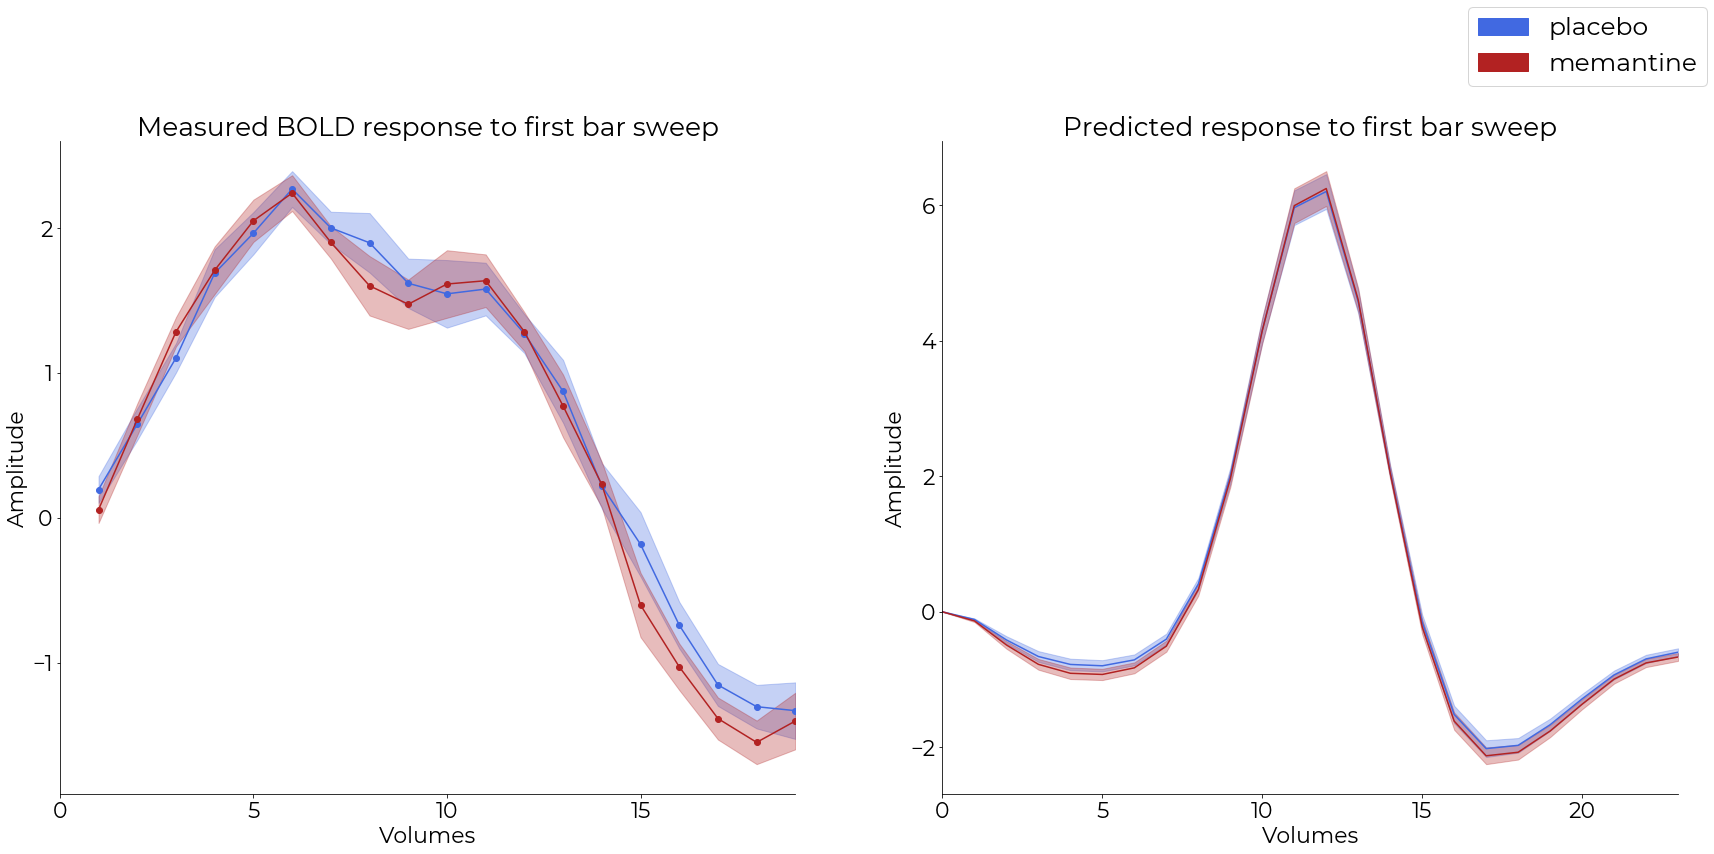

In [100]:
fig, axes = plt.subplots(1,2, figsize=(29, 12))
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 22})

################# PANEL A: ACTUAL TIME COURSE ########################
subavgs = {sub: np.mean(np.vstack([meandict_temporal[sub][condition]['bold']['mean'] for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
grandavg = np.mean(np.vstack([meandict_temporal[sub][condition]['bold']['mean'] for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

meandict_temporal_corrected = {sub: {condition: meandict_temporal[sub][condition]['bold']['mean']-subavgs[sub]+grandavg for condition in ['placebo','memantine']} for sub in newsubs}

for index, condition in enumerate(['placebo', 'memantine']):
    mean_allsubs = np.mean(np.vstack([meandict_temporal[sub][condition]['bold']['mean'] for sub in newsubs]), axis=0)

    sem_allsubs = np.std(np.vstack([meandict_temporal_corrected[sub][condition] for sub in newsubs]), axis=0)/np.sqrt(len(newsubs))

    ci_allsubs = 1.96*sem_allsubs
    
    axes[0].plot(mean_allsubs, color = colorlist[condition], marker='o')
    axes[0].fill_between(range(38), mean_allsubs-ci_allsubs, mean_allsubs+ci_allsubs, color = colorlist[condition], alpha=0.3)

axes[0].set_xlim(8,27)
axes[0].set_title("Measured BOLD response to first bar sweep")
axes[0].set_ylabel("Amplitude")
axes[0].set_xlabel("Volumes")
axes[0].set_xticks(range(8,27,5), range(0,19,5))


################# PANEL B: PREDICTED TIME COURSE ########################
subavgs = {sub: np.mean(np.vstack([meandict_temporal[sub][condition]['prediction']['mean'] for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
grandavg = np.mean(np.vstack([meandict_temporal[sub][condition]['prediction']['mean'] for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

meandict_temporal_corrected = {sub: {condition: meandict_temporal[sub][condition]['prediction']['mean']-subavgs[sub]+grandavg for condition in ['placebo','memantine']} for sub in newsubs}

for index, condition in enumerate(['placebo', 'memantine']):
    mean_allsubs = np.mean(np.vstack([meandict_temporal[sub][condition]['prediction']['mean'] for sub in newsubs]), axis=0)

    sem_allsubs = np.std(np.vstack([meandict_temporal_corrected[sub][condition] for sub in newsubs]), axis=0)/np.sqrt(len(newsubs))

    ci_allsubs = 1.96*sem_allsubs

    axes[1].plot(mean_allsubs, color = colorlist[condition])
    axes[1].fill_between(range(35), mean_allsubs-ci_allsubs, mean_allsubs+ci_allsubs, color = colorlist[condition], alpha=0.3)

axes[1].set_xlim(11,34)
axes[1].set_title("Predicted response to first bar sweep")
axes[1].set_ylabel("Amplitude")
axes[1].set_xlabel("Volumes")
axes[1].set_xticks(range(11,34,5), range(0,23,5))

fig.legend(handles=[placebo_patch, memantine_patch], ncol=1, fontsize=25, bbox_to_anchor=(0.92,1.05))

sns.despine()

save_path = f"/data1/projects/Meman1/projects/pilot/code/kelcey/snellius/images/V1_temporalsuppression_midecc.png"

plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

Test the one point that differs between the two conditions:

In [43]:
mean_bold_allsubs_placebo_9 = np.array([meandict_temporal[sub]['placebo']['bold']['mean'][9] for sub in newsubs])
mean_bold_allsubs_memantine_9 = np.array([meandict_temporal[sub]['memantine']['bold']['mean'][9] for sub in newsubs])

mean_bold_allsubs_placebo_23 = np.array([meandict_temporal[sub]['placebo']['bold']['mean'][23] for sub in newsubs])
mean_bold_allsubs_memantine_23 = np.array([meandict_temporal[sub]['memantine']['bold']['mean'][23] for sub in newsubs])

In [44]:
print("Paired t-test for point 9:", ttest_rel(mean_bold_allsubs_placebo_9, mean_bold_allsubs_memantine_9))
print("Paired t-test for point 23:", ttest_rel(mean_bold_allsubs_placebo_23, mean_bold_allsubs_memantine_23))

Paired t-test for point 9: Ttest_relResult(statistic=3.355569043002686, pvalue=0.007296565699381439)
Paired t-test for point 23: Ttest_relResult(statistic=1.8477531555895952, pvalue=0.09439211688765607)


<h2>4. Effect of memantine on individual model parameters</h2>

In [274]:
# Characteristics of eccentricity bins for all parameters over 10 bins 
params_metrics = ['A', 'B', 'C', 'prf_size', 'surr_size', 'phi', 'suppression index', 'minimum', 'maximum', 'min/max', 'fwhm', 'fwmin']
num_bins=10
bin_edges = np.linspace(0.5,4.5, num_bins+1)
eccentricity_range = [0.5, 4.5]

# Initialize dictionary with mean values for parameters, profiles and bar plots
meandict = {
    sub: {
        condition: {
            'scatter': {},
            'profile': {'mean': {}, 'ci': {}},
            'bar': {}
        } for condition in ['placebo', 'memantine']
    } | {'difference': {}}
    for sub in conditions.keys()}



# Plot 1: Metric versus Eccentricity in both conditions

for index, sub in enumerate(conditions.keys()):

    if sub == 'sub-015':
        print('sub-015 has technical issues, skipping..')
        continue
    print(f'working on {sub}')

    
    valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]
    print(f' vertices before: {sub}: plac: {len(valid_vertices_V1_plac)}, mem:{len(valid_vertices_V1_mem)}')
    # Only select vertices that had r2>= 0.3 for both conditions
    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>=0.3 and 
                                prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>=0.3)]
    
    ############## 1. CALCULATE DIFFERENCES #####################
    filtered_params_plac = prffits[sub]['fits']['placebo'].params.loc[valid_vertices_V1_shared]
    filtered_params_mem = prffits[sub]['fits']['memantine'].params.loc[valid_vertices_V1_shared]
    print(f' vertices after: {sub}: {len(filtered_params_plac)}, {len(filtered_params_mem)}')
        # Create new dataframe with differences
    for metric in params_metrics:
        diff_df = pd.DataFrame(columns=['vertex_nr', f'{metric} diff', 'mean_ecc','mean_r2'])
        diff_df['vertex_nr'] = valid_vertices_V1_shared
        diff_df[f'{metric} diff'] = filtered_params_plac[metric].values-filtered_params_mem[metric].values



        for param in ['ecc','r2']:
            diff_df[f'mean_{param}'] = np.median([filtered_params_plac[param], filtered_params_mem[param]], axis=0)


        # Now, calculate the difference while grouped in eccentricity bins
        shapemetrics_V1 = diff_df.dropna(subset=f'{metric} diff')

        # Calculate the bin edges based on the combined data
        all_ecc_values = pd.concat([prffits[sub]['fits']['placebo'].params.loc[valid_vertices_V1_shared]['ecc'],
                            prffits[sub]['fits']['memantine'].params.loc[valid_vertices_V1_shared]['ecc']])
        
        ecc_bin_edges = pd.cut(all_ecc_values, bins=num_bins, retbins=True, labels=False, include_lowest=True)[1]
        ecc_bin_edges[0] = ecc_bin_edges[0] - 1e-6  # Shift lower bound slightly to include extreme values
        ecc_bin_edges[-1] = ecc_bin_edges[-1] + 1e-6

        # Calculate eccentricity bins for each ROI
        shapemetrics_V1['eccentricity_bin'] = pd.cut(shapemetrics_V1['mean_ecc'], bins=ecc_bin_edges, labels=range(num_bins), include_lowest=False)

        # Calculate median for each group
        df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x['mean_ecc'], weights=x['mean_r2']) if len(x) > 0 else np.nan)
        df_mean_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x[f'{metric} diff'], weights=x['mean_r2']) if len(x) > 0 else np.nan)

        # Put in the dictionary
        meandict[sub]['difference']['mean_ecc'] = df_mean_ecc_v1
        meandict[sub]['difference']['mean_metric'] = df_mean_metric_v1

        for index, condition in enumerate(['placebo', 'memantine']):
            
            

            ############## 2. CALCULATE ECCENTRICITY VS METRIC PER CONDITION  ###################

            shapemetrics_V1 = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared].dropna(subset=metric)

            # Calculate eccentricity bins for each ROI

            shapemetrics_V1['eccentricity_bin'] = pd.cut(shapemetrics_V1['ecc'], bins = ecc_bin_edges, labels=range(num_bins), include_lowest=False)

            # Calculate mean for each group
            df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x['ecc'], weights=x['r2']) if len(x) > 0 else np.nan)
            df_mean_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x[metric], weights=x['r2']) if len(x) > 0 else np.nan)
            df_sem_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: np.std(x[metric]) / np.sqrt(len(x[metric])))

            meandict[sub][condition]['scatter']['mean_ecc'] = df_mean_ecc_v1
            meandict[sub][condition]['scatter'][f'mean_{metric}'] = df_mean_metric_v1
            meandict[sub][condition]['scatter'][f'sem_{metric}'] = df_sem_metric_v1  

working on sub-001
 vertices before: sub-001: plac: 1160, mem:1140
 vertices after: sub-001: 1080, 1080
working on sub-002
 vertices before: sub-002: plac: 2647, mem:2640
 vertices after: sub-002: 2447, 2447
working on sub-003
 vertices before: sub-003: plac: 2745, mem:2693
 vertices after: sub-003: 2506, 2506
working on sub-004
 vertices before: sub-004: plac: 2232, mem:2258
 vertices after: sub-004: 2128, 2128
working on sub-005
 vertices before: sub-005: plac: 2057, mem:2082
 vertices after: sub-005: 1923, 1923
working on sub-007
 vertices before: sub-007: plac: 2431, mem:2385
 vertices after: sub-007: 2318, 2318
working on sub-008
 vertices before: sub-008: plac: 2409, mem:2465
 vertices after: sub-008: 2275, 2275
working on sub-010
 vertices before: sub-010: plac: 1032, mem:1047
 vertices after: sub-010: 993, 993
working on sub-012
 vertices before: sub-012: plac: 2285, mem:2448
 vertices after: sub-012: 2053, 2053
working on sub-013
 vertices before: sub-013: plac: 3157, mem:3183

In [173]:
shapemetrics_V1.groupby('eccentricity_bin').size()

eccentricity_bin
0    148
1    236
2    264
3    191
4    190
5    212
6    162
7    223
8    140
9     61
dtype: int64

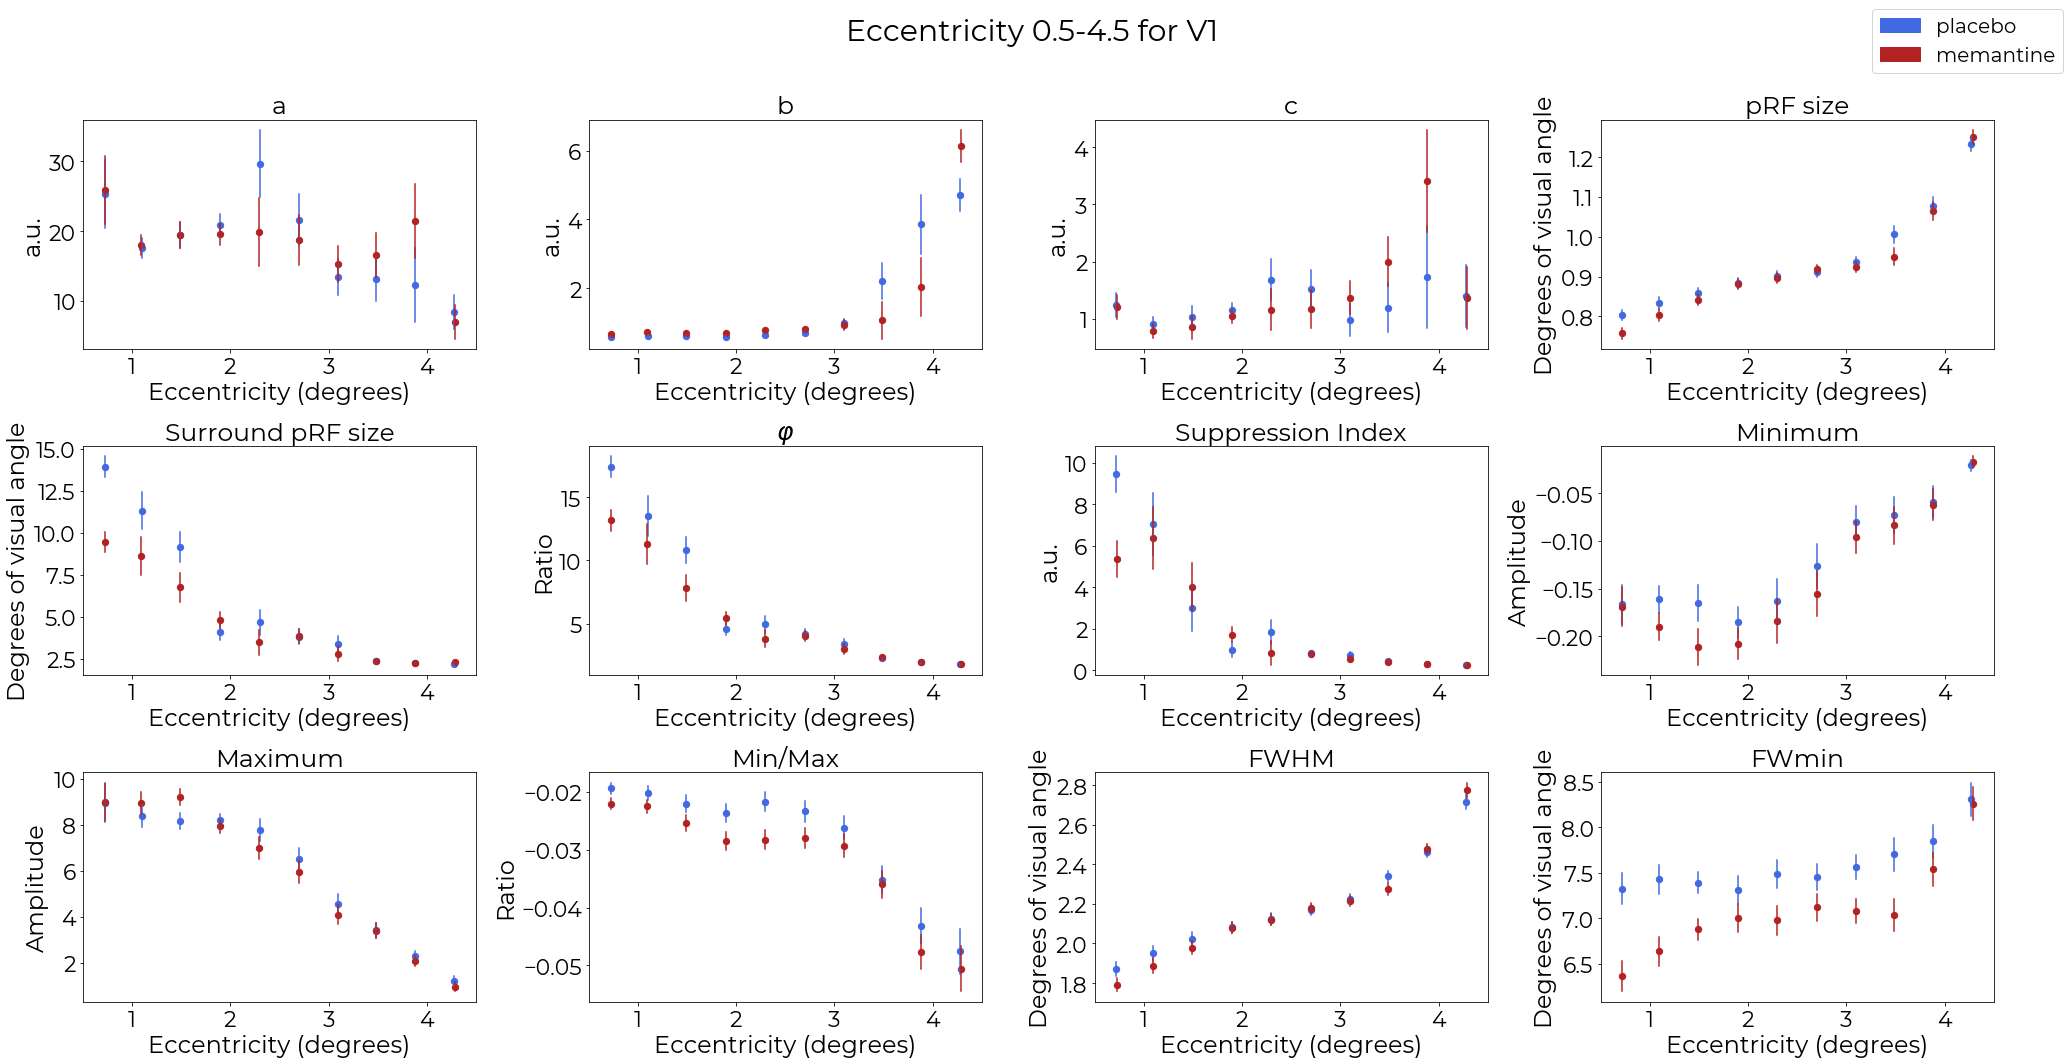

In [275]:
fig, axes = plt.subplots(3,4, figsize=(29, 15))
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 18})
params_title = {'A':'a', 'B':'b', 'C':'c', 'prf_size':'pRF size', 'surr_size': 'Surround pRF size', 'phi': '$φ$', 'suppression index': 'Suppression Index', 'minimum': 'Minimum', 'maximum':'Maximum', 'min/max':'Min/Max', 'fwhm':'FWHM', 'fwmin': 'FWmin'}
params_ylabels = {'A':'a.u.', 'B':'a.u.', 'C':'a.u.', 'prf_size':'Degrees of visual angle', 'surr_size': 'Degrees of visual angle', 'phi': 'Ratio', 'suppression index': 'a.u.', 'minimum': 'Amplitude', 'maximum':'Amplitude', 'min/max':'Ratio', 'fwhm':'Degrees of visual angle', 'fwmin': 'Degrees of visual angle'}

for i, metric in enumerate(params_metrics):
    ax = axes[i//4, i%4]
    subavgs_scatter = {sub: np.mean(np.vstack([meandict[sub][condition]['scatter'][f'mean_{metric}'].values for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
    grandavg_scatter = np.mean(np.vstack([meandict[sub][condition]['scatter'][f'mean_{metric}'].values for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

    meandict_scatter_corrected = {sub: {condition: meandict[sub][condition]['scatter'][f'mean_{metric}']-subavgs_scatter[sub]+grandavg_scatter for condition in ['placebo','memantine']} for sub in newsubs}

    for index, condition in enumerate(['placebo', 'memantine']):
        mean_ecc_allsubs = np.mean(pd.concat([meandict[sub][condition]['scatter']['mean_ecc'] for sub in newsubs], axis=1), axis=1) 
        mean_metric_allsubs = np.mean(pd.concat([meandict_scatter_corrected[sub][condition] for sub in newsubs], axis=1), axis=1)

        sem_metric_allsubs = np.std(pd.concat([meandict_scatter_corrected[sub][condition] for sub in newsubs], axis=1), axis=1)/np.sqrt(11)

        ax.scatter(mean_ecc_allsubs, mean_metric_allsubs, color=colorlist[condition], label=condition, s=40)

        for x, y, sem in zip(mean_ecc_allsubs.values, mean_metric_allsubs.values, sem_metric_allsubs.values):
            ax.plot([x, x], [y - sem, y + sem], color=colorlist[condition])
    

    ax.set_xlim([0.5,4.5])

    ax.set_ylabel(f'{params_ylabels[metric]}', fontsize=24)
    ax.set_title(f'{params_title[metric]}', fontsize=25)
    ax.set_xlabel(f'Eccentricity (degrees)', fontsize=24)
fig.suptitle("Eccentricity 0.5-4.5 for V1", fontsize=30)

fig.legend(handles=[placebo_patch, memantine_patch], loc='upper right', ncol=1, fontsize=20)
fig.tight_layout(h_pad=1,w_pad=1, rect=[0,0,0.97,0.97])
save_path = f"/data1/projects/Meman1/projects/pilot/code/kelcey/snellius/images/all_ecc_params_v1.png"
plt.savefig(save_path, dpi = 300)
plt.show()

In [255]:
# Define a dictionary to store t-statistics and p-values for each metric
results_dict = {metric: [] for metric in params_metrics}

# Significance threshold (e.g., 0.05)
alpha = 0.05

# Display eccentricity bin ranges
eccentricity_ranges = [(round(bin_edges[i], 3), round(bin_edges[i+1], 3)) for i in range(num_bins)]

# Loop through each metric and perform paired t-tests for each bin
for i, metric in enumerate(params_metrics):
    print(f"Performing paired t-tests for {metric}")
    
    # For each metric, iterate over all bins
    for bin_index in range(num_bins):
        placebo_bin = []
        memantine_bin = []

        # Collect data for each bin across all subjects
        for sub in newsubs:
            try:
                # Get the data for the current bin for both placebo and memantine for the current subject
                placebo_bin.append(meandict[sub]['placebo']['scatter'][f'mean_{metric}'].values[bin_index])
                memantine_bin.append(meandict[sub]['memantine']['scatter'][f'mean_{metric}'].values[bin_index])
            except IndexError:
                # In case there are missing data for some subjects, handle it appropriately
                print(f"Data missing for {sub} in bin {bin_index}, skipping...")

        # Perform the paired t-test for the current bin (if data exists)
        if len(placebo_bin) > 0 and len(memantine_bin) > 0:
            t_stat, p_value = ttest_rel(placebo_bin, memantine_bin, nan_policy='propagate') 
            results_dict[metric].append((eccentricity_ranges[bin_index], round(t_stat, 3), round(p_value, 3), p_value < alpha))
        else:
            # Append NaN if no data is available for the bin
            results_dict[metric].append((eccentricity_ranges[bin_index], np.nan, np.nan, False))  

    # Print the results with eccentricity ranges, t-statistics, p-values, and significance flag
    print(f"Results for {metric}:")
    for ecc_range, t_stat, p_val, is_significant in results_dict[metric]:
        # Mark significant values
        sig_marker = "***" if is_significant else ""  
        print(f"{ecc_range}: t-statistic = {t_stat}, p-value = {p_val} {sig_marker}")



Performing paired t-tests for A
Results for A:
(0.5, 0.9): t-statistic = -0.051, p-value = 0.96 
(0.9, 1.3): t-statistic = -0.146, p-value = 0.887 
(1.3, 1.7): t-statistic = -0.002, p-value = 0.999 
(1.7, 2.1): t-statistic = 0.421, p-value = 0.683 
(2.1, 2.5): t-statistic = 0.964, p-value = 0.358 
(2.5, 2.9): t-statistic = 0.393, p-value = 0.703 
(2.9, 3.3): t-statistic = -0.352, p-value = 0.732 
(3.3, 3.7): t-statistic = -0.513, p-value = 0.619 
(3.7, 4.1): t-statistic = -0.829, p-value = 0.427 
(4.1, 4.5): t-statistic = 0.267, p-value = 0.795 
Performing paired t-tests for B
Results for B:
(0.5, 0.9): t-statistic = -0.978, p-value = 0.351 
(0.9, 1.3): t-statistic = -1.275, p-value = 0.231 
(1.3, 1.7): t-statistic = -0.916, p-value = 0.381 
(1.7, 2.1): t-statistic = -1.814, p-value = 0.1 
(2.1, 2.5): t-statistic = -1.546, p-value = 0.153 
(2.5, 2.9): t-statistic = -0.71, p-value = 0.494 
(2.9, 3.3): t-statistic = 0.189, p-value = 0.854 
(3.3, 3.7): t-statistic = 1.024, p-value = 0.33 

In [257]:
# Characteristics of eccentricity bins, computed by median and eccentricity bins based off of pd.cut 
normalize_profiles = True
num_bins=20
bin_edges = np.linspace(0.5,4.5, num_bins+1)
metric = 'min/max'

# Calculate the necessary metrics for all the subjects and saving them

meandict = {
    sub: {
        condition: {
            'scatter': {},
            'profile': {'mean': {}, 'ci': {}},
            'profile_absolute': {'mean': {}, 'ci': {}},
            'bar': {}
        } for condition in ['placebo', 'memantine']
    } | {'difference': {}}
    for sub in conditions.keys()}



# Plot 1: Metric versus Eccentricity in both conditions

for index, sub in enumerate(conditions.keys()):

    if sub == 'sub-015':
        print('sub-015 has techinical issues, skipping..')
        continue
    print(f'working on {sub}')
    valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    # only select vertices that had r2>0.3 for at least one of the conditions
    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>0.3 and 
                                prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>0.3)]
   

    ############## 1. CALCULATE DIFFERENCES #####################
    filtered_params_plac = prffits[sub]['fits']['placebo'].params.loc[valid_vertices_V1_shared]
    filtered_params_mem = prffits[sub]['fits']['memantine'].params.loc[valid_vertices_V1_shared]
    
    # Create new dataframe with differences
    diff_df = pd.DataFrame(columns=['vertex_nr', f'{metric} diff', 'mean_ecc','mean_r2'])
    diff_df['vertex_nr'] = valid_vertices_V1_shared
    diff_df[f'{metric} diff'] = filtered_params_plac[metric].values-filtered_params_mem[metric].values



    for param in ['ecc','r2']:
        diff_df[f'mean_{param}'] = np.median([filtered_params_plac[param], filtered_params_mem[param]], axis=0)



    # Now, calculate the difference while grouped in eccentricity bins
    shapemetrics_V1 = diff_df.dropna(subset=f'{metric} diff')

      # Calculate the bin edges based on the combined data
    all_ecc_values = pd.concat([prffits[sub]['fits']['placebo'].params.loc[valid_vertices_V1_shared]['ecc'],
                        prffits[sub]['fits']['memantine'].params.loc[valid_vertices_V1_shared]['ecc']])
    
    ecc_bin_edges = pd.cut(all_ecc_values, bins=num_bins, retbins=True, labels=False, include_lowest=True)[1]
    ecc_bin_edges[0] = ecc_bin_edges[0] - 1e-6  # Shift lower bound slightly to include extreme values
    ecc_bin_edges[-1] = ecc_bin_edges[-1] + 1e-6

    # Calculate eccentricity bins for each ROI
    shapemetrics_V1['eccentricity_bin'] = pd.cut(shapemetrics_V1['mean_ecc'], bins=ecc_bin_edges, labels=range(num_bins), include_lowest=False)



    # Calculate median for each group
    df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x['mean_ecc'], weights=x['mean_r2']))
    df_mean_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x[f'{metric} diff'], weights=x['mean_r2']))
    

    # Put in the dictionary
    meandict[sub]['difference']['mean_ecc'] = df_mean_ecc_v1
    meandict[sub]['difference']['mean_metric'] = df_mean_metric_v1

  
    for index, condition in enumerate(['placebo', 'memantine']):

        

        ############## 2. CALCULATE ECCENTRICITY VS METRIC PER CONDITION  ###################

        shapemetrics_V1 = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared].dropna(subset=metric)



       # shapemetrics_V1['eccentricity_bin'] = pd.qcut(shapemetrics_V1['ecc'], q=num_bins, labels=range(10))
        shapemetrics_V1['eccentricity_bin'] = pd.cut(shapemetrics_V1['ecc'], bins = ecc_bin_edges, labels=range(num_bins), include_lowest=False)

        # Calculate mean for each group

        df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x['ecc'], weights=x['r2']))
        df_mean_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x[metric], weights=x['r2']))
        df_sem_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: np.std(x[metric]) / np.sqrt(len(x[metric])))

        meandict[sub][condition]['scatter']['mean_ecc'] = df_mean_ecc_v1
        meandict[sub][condition]['scatter']['mean_metric'] = df_mean_metric_v1
        meandict[sub][condition]['scatter']['sem_metric'] = df_sem_metric_v1



    
        ############## 4. CALCULATE PROFILES FOR SIGNIFICANT ECC  ###################

        shapemetrics_significant = shapemetrics_V1[(shapemetrics_V1['ecc'] >= 0.5) & (shapemetrics_V1['ecc'] <= 1.5)]

    
        allprofiles_significant = {'vertex': [],'r2': [],'profile': [], 'profile_absolute': []}

        for row in shapemetrics_significant.iterrows():
            profile = profile_fwhm_fwmin(row[1],normalizeprofile=normalize_profiles)
            profile_absolute = profile_fwhm_fwmin(row[1],normalizeprofile=False)

            if profile.size != 0:
                allprofiles_significant['vertex'].append(row[0])
                allprofiles_significant['r2'].append(shapemetrics_significant.loc[row[0]]['r2'])
                allprofiles_significant['profile'].append(profile)
                allprofiles_significant['profile_absolute'].append(profile_absolute)


        # Calculate mean

        mean_significant,_,_,ci_significant = get_mean_profile(np.vstack(allprofiles_significant['profile']), weighted=True, weights=allprofiles_significant['r2'])
        mean_significant_absolute,_,_,ci_significant_absolute = get_mean_profile(np.vstack(allprofiles_significant['profile_absolute']), weighted=True, weights=allprofiles_significant['r2'])
   

        meandict[sub][condition]['profile']['mean']['0.5-1.5'] = mean_significant
        meandict[sub][condition]['profile']['ci']['0.5-1.5'] = ci_significant

        meandict[sub][condition]['profile_absolute']['mean']['0.5-1.5'] = mean_significant_absolute
        meandict[sub][condition]['profile_absolute']['ci']['0.5-1.5'] = ci_significant_absolute
 

working on sub-001
working on sub-002
working on sub-003
working on sub-004
working on sub-005
working on sub-007
working on sub-008
working on sub-010
working on sub-012
working on sub-013
sub-015 has techinical issues, skipping..
working on sub-016


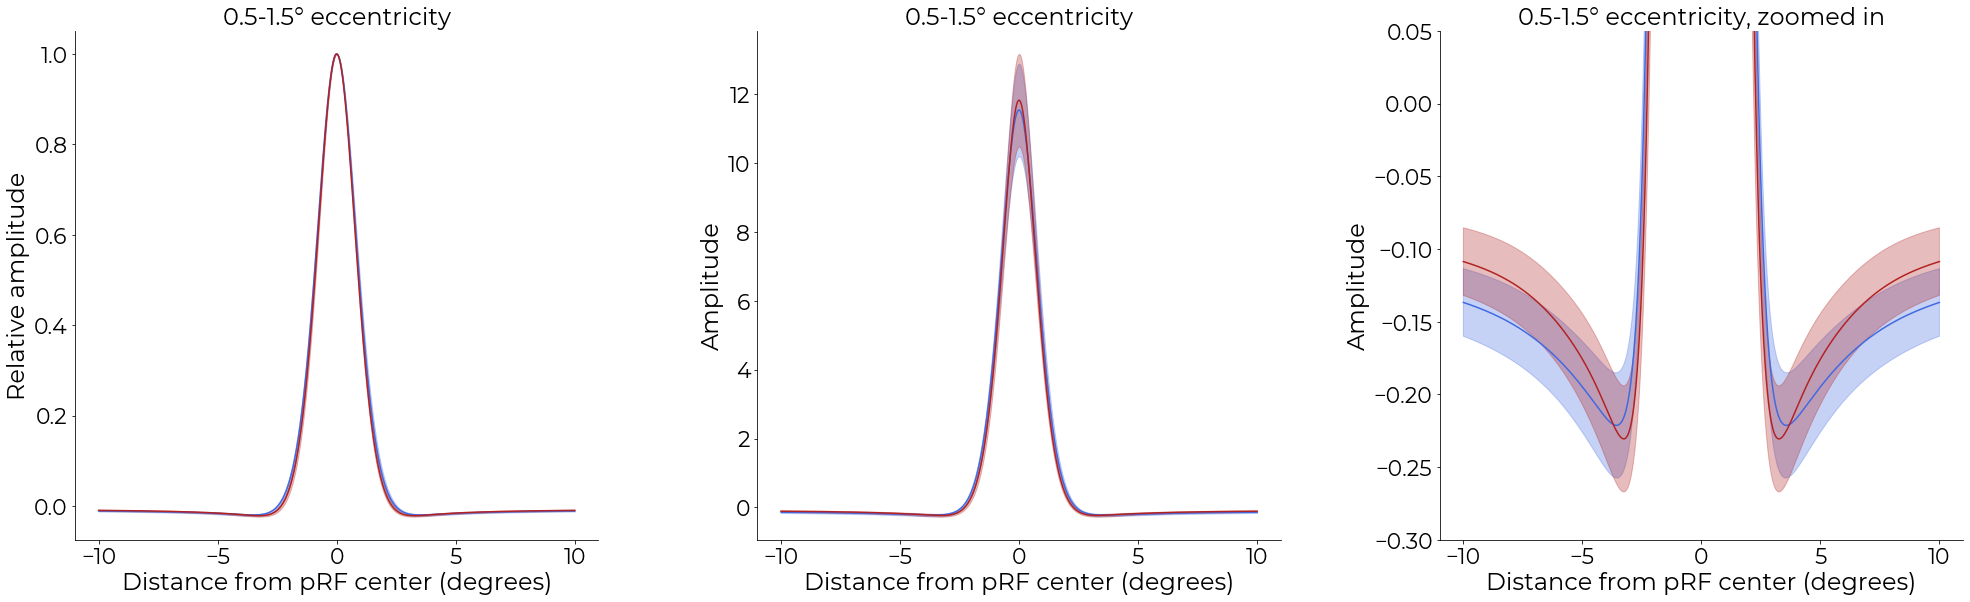

In [258]:
colorlist = {'placebo':'royalblue','memantine':'firebrick'}
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 22})

# Create the figure
fig, axes = plt.subplots(1,3, figsize=(29, 10),sharex='col')

######### PROFILE PANELS #########

for jndex, ecc in enumerate(['0.5-1.5']):

    subavgs = {sub: np.mean(np.vstack([meandict[sub][condition]['profile']['mean'][ecc] for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
    grandavg = np.mean(np.vstack([meandict[sub][condition]['profile']['mean'][ecc] for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

    meandict_corrected = {sub: {condition: meandict[sub][condition]['profile']['mean'][ecc]-subavgs[sub]+grandavg for condition in ['placebo','memantine']} for sub in newsubs}
        
    for condition in ['placebo', 'memantine']:
        mean_allsubs = np.mean(np.vstack([meandict[sub][condition]['profile']['mean'][ecc] for sub in newsubs]), axis=0)

        sem_allsubs = np.std(np.vstack([meandict_corrected[sub][condition] for sub in newsubs]), axis=0)/np.sqrt(11)

        ci_allsubs = 1.96*sem_allsubs

        axes[jndex].plot(np.linspace(-10,10, 2000), mean_allsubs, color = colorlist[condition])
        axes[jndex].fill_between(np.linspace(-10,10, 2000), mean_allsubs-ci_allsubs, mean_allsubs+ci_allsubs, color = colorlist[condition], alpha=0.3)

        axes[jndex].set_xlabel('Distance from pRF center (degrees)', fontsize=24)
        axes[jndex].set_ylabel('Relative amplitude', fontsize=24)
        axes[jndex].set_title(f'{ecc}° eccentricity', fontsize=24)

for jndex, ecc in enumerate(['0.5-1.5']):

    subavgs_abs = {sub: np.mean(np.vstack([meandict[sub][condition]['profile_absolute']['mean'][ecc] for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
    grandavg_abs = np.mean(np.vstack([meandict[sub][condition]['profile_absolute']['mean'][ecc] for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

    meandict_corrected = {sub: {condition: meandict[sub][condition]['profile_absolute']['mean'][ecc]-subavgs_abs[sub]+grandavg_abs for condition in ['placebo','memantine']} for sub in newsubs}
        
    for condition in ['placebo', 'memantine']:
        mean_allsubs_abs = np.mean(np.vstack([meandict[sub][condition]['profile_absolute']['mean'][ecc] for sub in newsubs]), axis=0)

        sem_allsubs_abs = np.std(np.vstack([meandict_corrected[sub][condition] for sub in newsubs]), axis=0)/np.sqrt(len(newsubs))

        ci_allsubs_abs = 1.96*sem_allsubs_abs

        axes[1 +jndex].plot(np.linspace(-10,10, 2000), mean_allsubs_abs, color = colorlist[condition])
        axes[1 +jndex].fill_between(np.linspace(-10,10, 2000), mean_allsubs_abs-ci_allsubs_abs, mean_allsubs_abs+ci_allsubs_abs, color = colorlist[condition], alpha=0.3)


        axes[1 +jndex].set_xlabel('Distance from pRF center (degrees)', fontsize=24)
        axes[1 +jndex].set_ylabel('Amplitude', fontsize=24)
        axes[1 +jndex].set_title(f'{ecc}° eccentricity', fontsize=24)

        #Zoomed in the surround 
        axes[2 +jndex].plot(np.linspace(-10,10, 2000), mean_allsubs_abs, color = colorlist[condition])
        axes[2 +jndex].fill_between(np.linspace(-10,10, 2000), mean_allsubs_abs-ci_allsubs_abs, mean_allsubs_abs+ci_allsubs_abs, color = colorlist[condition], alpha=0.3)

        axes[2 +jndex].set_ylim(-0.3, 0.05)
        axes[2 +jndex].set_xlabel('Distance from pRF center (degrees)', fontsize=24)
        axes[2 +jndex].set_ylabel('Amplitude', fontsize=24)
        axes[2 +jndex].set_title(f'{ecc}° eccentricity, zoomed in', fontsize=24)
sns.despine()
# Adjust the layout
plt.tight_layout(pad=3.0)

save_path = f"/data1/projects/Meman1/projects/pilot/code/kelcey/snellius/images/V1_profiles_significant.png"
# Display the plot

plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

In [259]:
dfs = []

for sub in newsubs:
    print("Working on", sub)
    
    valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['placebo'].params.index]
    valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if vertex in prffits[sub]['fits']['memantine'].params.index]

    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>=0.3 and 
                                prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>=0.3)]
    
    for condition in ['placebo','memantine']:
        filtered_params = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared]
        
        for ecc_range in [(0.5,1.5)]:
        #for ecc_range in [(0.5,2.5), (2.5,4.5)]:                      
            filtered_params_ecc = filtered_params.loc[(filtered_params['ecc']>ecc_range[0]) & (filtered_params['ecc']<ecc_range[1])]
            
            mean_metric,_,_ = get_descriptives(filtered_params_ecc, 'min/max',weighted=True)

            data = {'sub':sub,
                    'condition':condition,
                    'eccentricity':f'{str(ecc_range[0])}-{str(ecc_range[1])}', 
                    'minmax': mean_metric}
            
            dfs.append(data)
            
mean_metric_df = pd.DataFrame(dfs)

Working on sub-001
Working on sub-002
Working on sub-003
Working on sub-004
Working on sub-005
Working on sub-007
Working on sub-008
Working on sub-010
Working on sub-012
Working on sub-013
Working on sub-016


In [260]:
# Get the unique eccentricity ranges from the DataFrame
eccentricity_ranges = mean_metric_df['eccentricity'].unique()

# Loop through each eccentricity bin
for ecc_range in eccentricity_ranges:
    # Get the placebo values for this eccentricity range
    placebo_values = mean_metric_df.loc[(mean_metric_df['condition'] == 'placebo') & 
                                        (mean_metric_df['eccentricity'] == ecc_range)]['minmax']
    
    # Get the memantine values for this eccentricity range
    memantine_values = mean_metric_df.loc[(mean_metric_df['condition'] == 'memantine') & 
                                          (mean_metric_df['eccentricity'] == ecc_range)]['minmax']
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(placebo_values, memantine_values)
    
    # Calculate degrees of freedom
    df = len(placebo_values) - 1  # since paired test, both lists are of equal length
    
    # Output the results
    print(f"Paired t-test for {ecc_range} ecc: t({df}) = {t_stat:.2f}, p = {p_value:.3f}")


Paired t-test for 0.5-1.5 ecc: t(10) = 0.93, p = 0.376


In [327]:
##Predicted response to significant ecc 

meandict_temporal = {sub: {condition: {'prediction': {}, 'bold': {}, 'hrf': {}} for condition in ['placebo', 'memantine']} for sub in newsubs}

for index, sub in enumerate(newsubs):
    print("working on",  sub)

    # Collect valid vertices for both conditions
    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2'] >= 0.3 and 
                                 prffits[sub]['fits']['memantine'].params.loc[vertex]['r2'] >= 0.3)]

    for i, condition in enumerate(['placebo', 'memantine']):
        models = prffits[sub]['fits'][condition].pRFmodelFitting  
        models.norm_model.stimulus = prf_stim
        params_valid = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared]

        # Filter vertices based on eccentricity
        valid_vertices_V1_shared_lowecc = params_valid[(params_valid['ecc'] >= 0.5) & (params_valid['ecc'] <= 1.5)].index
        params_valid_lowecc = models.norm_iter[valid_vertices_V1_shared_lowecc, ...]

        #################### FIRST, CALCULATE PREDICTED TIME COURSES ###############
        # Vectorized time course calculation if possible
        timecourses = np.array([timecourse_at_zero(models, row) for row in params_valid_lowecc])
        timecourses_array = timecourses.reshape(timecourses.shape[0], 35)
        print(timecourses_array.shape)

        # Optimized weighted mean and CI calculation
        mean, std, sem, ci = get_mean_profile(timecourses_array, weighted=True, weights=params_valid_lowecc[:, -1])
        meandict_temporal[sub][condition]['prediction']['mean'] = mean
        meandict_temporal[sub][condition]['prediction']['ci'] = ci


working on sub-001
(410, 35)
[ 3.19589197e-08  1.53005718e-08 -1.42085459e-08  2.88286692e-08
 -3.76589493e-09 -8.73115730e-09 -1.21003799e-08 -2.36444019e-08
 -1.93228438e-08 -2.42044751e-08 -6.71551809e-09  6.24830090e-09
 -5.15512408e-02 -2.46386923e-01 -4.98061804e-01 -7.11329500e-01
 -8.50318139e-01 -9.04466792e-01 -8.46269705e-01 -5.85762877e-01
  1.91824832e-02  1.00644737e+00  2.15832323e+00  2.95862421e+00
  2.97728342e+00  2.25915900e+00  1.19234358e+00  1.74976107e-01
 -5.67703882e-01 -9.98776105e-01 -1.17430951e+00 -1.16405122e+00
 -1.04126904e+00 -9.11228902e-01 -8.40807308e-01]
(410, 35)
[ 3.09984547e-08  1.05407076e-08 -1.51373588e-08  3.00543183e-08
  4.20986076e-09 -3.09169221e-09 -4.74402386e-09 -1.84813213e-08
 -1.66234103e-08 -1.86098424e-08 -7.70725732e-09  7.41876296e-09
 -3.88947099e-02 -1.85958364e-01 -3.89057241e-01 -5.82275483e-01
 -7.28824055e-01 -8.04005325e-01 -7.60590406e-01 -4.83331232e-01
  1.83841760e-01  1.24820417e+00  2.43813239e+00  3.22599002e+00
 

KeyboardInterrupt: 

In [330]:
##Predicted response to significant ecc 
meandict_temporal = {sub: {condition: {'prediction': {}, 'bold': {}, 'hrf': {}} for condition in ['placebo', 'memantine']} for sub in newsubs}

for index, sub in enumerate(newsubs):
    print("working on",  sub)

    # Collect valid vertices for both conditions
    valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices']['V1_vertices'] if 
                                vertex in prffits[sub]['fits']['placebo'].params.index and 
                                vertex in prffits[sub]['fits']['memantine'].params.index and
                                (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2'] >= 0.3 and 
                                 prffits[sub]['fits']['memantine'].params.loc[vertex]['r2'] >= 0.3)]

    for i, condition in enumerate(['placebo', 'memantine']):
        models = prffits[sub]['fits'][condition].pRFmodelFitting  
        models.norm_model.stimulus = prf_stim2
        params_valid = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared]

        # Filter vertices based on eccentricity
        valid_vertices_V1_shared_lowecc = params_valid[(params_valid['ecc'] >= 0.5) & (params_valid['ecc'] <= 1.5)].index
        params_valid_lowecc = models.norm_iter[valid_vertices_V1_shared_lowecc, ...]

        #################### CALCULATE PREDICTED TIME COURSES ###############
        # Vectorized time course calculation if possible
        timecourses = np.array([timecourse_at_zero(models, row) for row in params_valid_lowecc])
        timecourses = np.squeeze(timecourses)

        # Select all bar sweeps
        timecourses_array_1 = timecourses[:, 15:35]
        timecourses_array_2 = timecourses[:, 35:55]
        timecourses_array_3 = timecourses[:, 70:90]
        timecourses_array_4 = timecourses[:, 90:110]
        timecourses_array_5 = timecourses[:, 125:145]
        timecourses_array_6 = timecourses[:, 145:165]
        timecourses_array_7 = timecourses[:, 180:200]
        timecourses_array_8 = timecourses[:, 200:220]
        timecourse_arrays = [timecourses_array_1, timecourses_array_2, timecourses_array_3, timecourses_array_4, timecourses_array_5, timecourses_array_6, timecourses_array_7, timecourses_array_8]
        aligned_arrays = []

        # Get the length of each array (assumes they are of equal length)
        array_length = timecourses_array_1.shape[1]  # Assuming all arrays are the same size

        # The center index of each array (where we want the max to be centered)
        center_index = array_length // 2  # This is the center

        # Find max index for each array and shift
        for array in timecourse_arrays:
            # Find the index of the max value
            max_index = np.argmax(np.mean(array, axis=0))  # Find max along time axis
            
            #Shift array to center the max
            shift_amount = center_index - max_index
            aligned_array = np.roll(array, shift_amount, axis=1)  # Shift along the time axis
            
            # Add aligned array to the list
            aligned_arrays.append(aligned_array)

        # Compute the average across the 8 aligned arrays
        aligned_arrays_stack = np.vstack(aligned_arrays)  #
        # Make sure weights correspond to the number of profiles in aligned_arrays_stack
        n_profiles = aligned_arrays_stack.shape[0] // 8  
        weights_prediction = np.repeat(params_valid_lowecc[:n_profiles, -1], 8)  

        # Now pass this corrected weight array to the function
        mean, std, sem, ci = get_mean_profile(aligned_arrays_stack, weighted=True, weights=weights_prediction)
        meandict_temporal[sub][condition]['prediction']['mean'] = mean
        meandict_temporal[sub][condition]['prediction']['ci'] = ci




working on sub-001
working on sub-002
working on sub-003
working on sub-004
working on sub-005
working on sub-007
working on sub-008
working on sub-010
working on sub-012
working on sub-013
working on sub-016


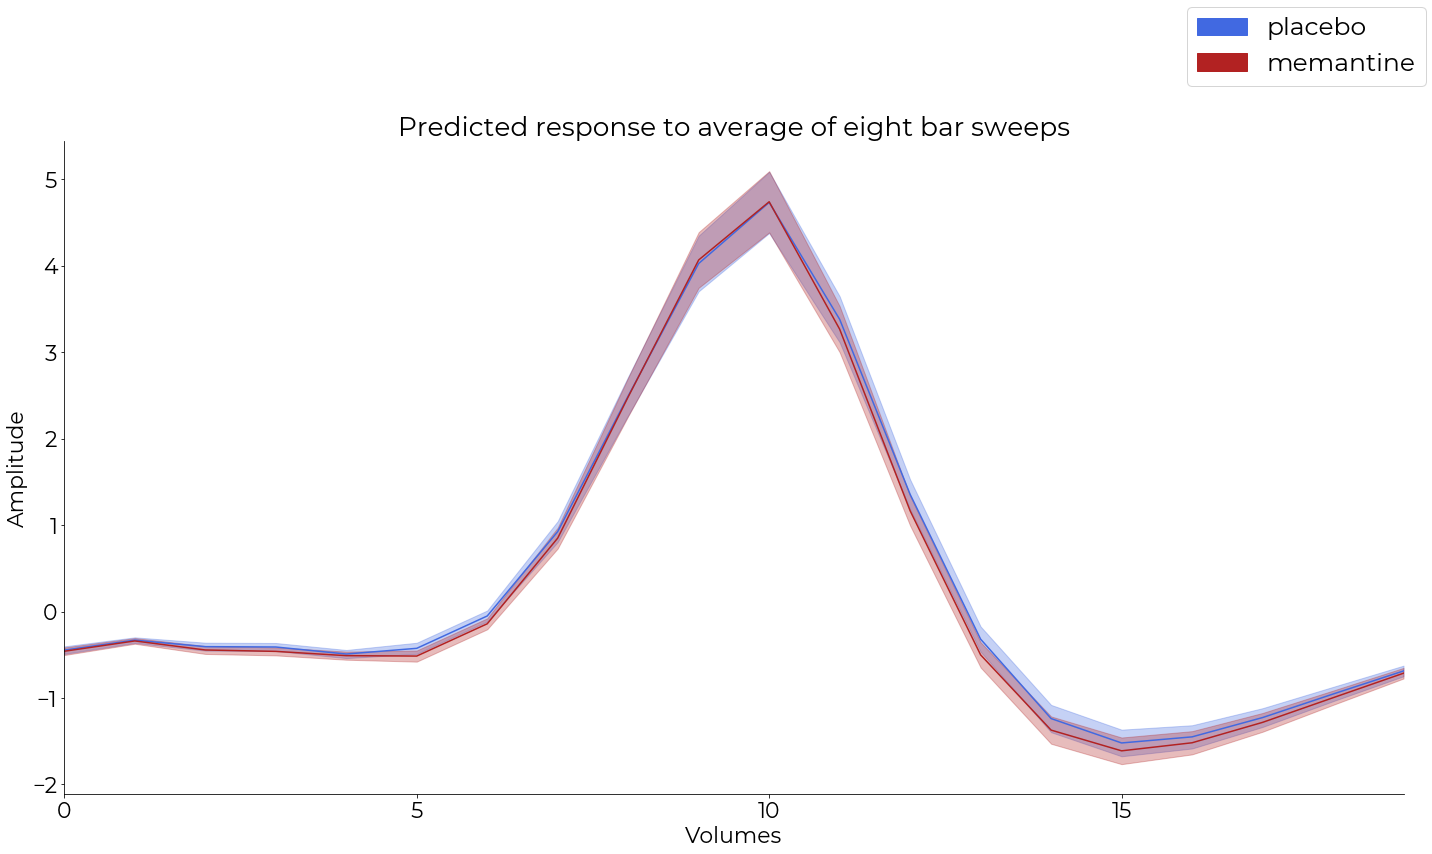

In [334]:
fig, axes = plt.subplots(1,1, figsize=(24, 12))
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 22})


################# PANEL B: PREDICTED TIME COURSE ########################
subavgs = {sub: np.mean(np.vstack([meandict_temporal[sub][condition]['prediction']['mean'] for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
grandavg = np.mean(np.vstack([meandict_temporal[sub][condition]['prediction']['mean'] for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

meandict_temporal_corrected = {sub: {condition: meandict_temporal[sub][condition]['prediction']['mean']-subavgs[sub]+grandavg for condition in ['placebo','memantine']} for sub in newsubs}

for index, condition in enumerate(['placebo', 'memantine']):
    mean_allsubs = np.mean(np.vstack([meandict_temporal[sub][condition]['prediction']['mean'] for sub in newsubs]), axis=0)

    sem_allsubs = np.std(np.vstack([meandict_temporal_corrected[sub][condition] for sub in newsubs]), axis=0)/np.sqrt(len(newsubs))

    ci_allsubs = 1.96*sem_allsubs

    axes.plot(mean_allsubs, color = colorlist[condition])
    axes.fill_between(range(20), mean_allsubs-ci_allsubs, mean_allsubs+ci_allsubs, color = colorlist[condition], alpha=0.3)

axes.set_xlim(0,19)
axes.set_title("Predicted response to average of eight bar sweeps")
axes.set_ylabel("Amplitude")
axes.set_xlabel("Volumes")
axes.set_xticks(range(0,19,5), range(0,19,5))

fig.legend(handles=[placebo_patch, memantine_patch], ncol=1, fontsize=25, bbox_to_anchor=(0.92,1.05))

sns.despine()

save_path = f"/data1/projects/Meman1/projects/pilot/code/kelcey/snellius/images/V1_temporalsuppression_midecc_withoutBOLD.png"

plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

In [124]:
mean_bold_allsubs_placebo_2 = np.array([meandict_temporal[sub]['placebo']['bold']['mean'][9] for sub in newsubs])
mean_bold_allsubs_memantine_2 = np.array([meandict_temporal[sub]['memantine']['bold']['mean'][9] for sub in newsubs])

mean_bold_allsubs_placebo_23 = np.array([meandict_temporal[sub]['placebo']['bold']['mean'][23] for sub in newsubs])
mean_bold_allsubs_memantine_23 = np.array([meandict_temporal[sub]['memantine']['bold']['mean'][23] for sub in newsubs])

In [125]:
print("Paired t-test for point 2:", ttest_rel(mean_bold_allsubs_placebo_2, mean_bold_allsubs_memantine_2))
print("Paired t-test for point 23:", ttest_rel(mean_bold_allsubs_placebo_23, mean_bold_allsubs_memantine_23))

Paired t-test for point 2: Ttest_relResult(statistic=2.1763777949805116, pvalue=0.054578615225996566)
Paired t-test for point 23: Ttest_relResult(statistic=2.5356288388286115, pvalue=0.029584037713443884)


In [336]:
##look at fwmin for ALL rois 
# Characteristics of eccentricity bins for all parameters over 10 bins 
num_bins=10
eccentricity_range = [0.5, 4.5]
# Calculate the necessary metrics for all the subjects and saving them

meandict = {
    sub: {
        roi: {
            condition: {
                'scatter': {},
                'profile': {'mean': {}, 'ci': {}},
                'bar': {}
            }
            for condition in ['placebo', 'memantine']
        }
        for roi in prffits[sub]['roi_vertices'].keys()
    } | {'difference': {}}
    for sub in conditions.keys()
}


# Plot 1: Metric versus Eccentricity in both conditions

for index, sub in enumerate(conditions.keys()):

    if sub == 'sub-015':
        print('sub-015 has technical issues, skipping..')
        continue
    print(f'working on {sub}')

    for roi in prffits['sub-001']['roi_vertices'].keys():

        valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if vertex in prffits[sub]['fits']['placebo'].params.index]
        valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if vertex in prffits[sub]['fits']['memantine'].params.index]

        # Only select vertices that had r2>0.3 for at least one of the conditions
        valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if 
                                    vertex in prffits[sub]['fits']['placebo'].params.index and 
                                    vertex in prffits[sub]['fits']['memantine'].params.index and
                                    (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>=0.3 and 
                                    prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>=0.3)]
        
        ############## 1. CALCULATE DIFFERENCES #####################
        filtered_params_plac = prffits[sub]['fits']['placebo'].params.loc[valid_vertices_V1_shared]
        filtered_params_mem = prffits[sub]['fits']['memantine'].params.loc[valid_vertices_V1_shared]
        print(f'{roi} vertices before: : {len(valid_vertices_V1_plac)}, after: {len(filtered_params_plac)}')
        if len(filtered_params_plac) == 0:
            print(f'{roi} has no vertices due to filtering, skipping..')
            continue
        
            # Create new dataframe with differences
        for metric in ['fwmin']:
            diff_df = pd.DataFrame(columns=['vertex_nr', f'{metric} diff', 'mean_ecc','mean_r2'])
            diff_df['vertex_nr'] = valid_vertices_V1_shared
            diff_df[f'{metric} diff'] = filtered_params_plac[metric].values-filtered_params_mem[metric].values



            for param in ['ecc','r2']:
                diff_df[f'mean_{param}'] = np.median([filtered_params_plac[param], filtered_params_mem[param]], axis=0)


            # Now, calculate the difference while grouped in eccentricity bins
            shapemetrics_V1 = diff_df.dropna(subset=f'{metric} diff')

            # Calculate the bin edges based on the combined data
            all_ecc_values = pd.concat([prffits[sub]['fits']['placebo'].params.loc[valid_vertices_V1_shared]['ecc'],
                                prffits[sub]['fits']['memantine'].params.loc[valid_vertices_V1_shared]['ecc']])
            
            ecc_bin_edges = pd.cut(all_ecc_values, bins=num_bins, retbins=True, labels=False, include_lowest=True)[1]
            ecc_bin_edges[0] = ecc_bin_edges[0] - 1e-6  # Shift lower bound slightly to include extreme values
            ecc_bin_edges[-1] = ecc_bin_edges[-1] + 1e-6

            # Calculate eccentricity bins for each ROI
            shapemetrics_V1['eccentricity_bin'] = pd.cut(shapemetrics_V1['mean_ecc'], bins=ecc_bin_edges, labels=range(num_bins), include_lowest=False)

            # Calculate median for each group
            df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x['mean_ecc'], weights=x['mean_r2']) if len(x) > 0 else np.nan)
            df_mean_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x[f'{metric} diff'], weights=x['mean_r2']) if len(x) > 0 else np.nan)

            # Put in the dictionary
            meandict[sub]['difference']['mean_ecc'] = df_mean_ecc_v1
            meandict[sub]['difference']['mean_metric'] = df_mean_metric_v1

            for index, condition in enumerate(['placebo', 'memantine']):
                
                

                ############## 2. CALCULATE ECCENTRICITY VS METRIC PER CONDITION  ###################

                shapemetrics_V1 = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared].dropna(subset=metric)

                # Calculate eccentricity bins for each ROI

                shapemetrics_V1['eccentricity_bin'] = pd.cut(shapemetrics_V1['ecc'], bins = ecc_bin_edges, labels=range(num_bins), include_lowest=False)

                # Calculate mean for each group
                df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x['ecc'], weights=x['r2']) if len(x) > 0 else np.nan)
                df_mean_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x[metric], weights=x['r2']) if len(x) > 0 else np.nan)
                # df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x['ecc'], weights=x['r2']))
                # df_mean_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x[metric], weights=x['r2']))
                df_sem_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: np.std(x[metric]) / np.sqrt(len(x[metric])))

                meandict[sub][roi][condition]['scatter']['mean_ecc'] = df_mean_ecc_v1
                meandict[sub][roi][condition]['scatter'][f'mean_{metric}'] = df_mean_metric_v1
                meandict[sub][roi][condition]['scatter'][f'sem_{metric}'] = df_sem_metric_v1  

working on sub-001
V1_vertices vertices before: : 1160, after: 1080
V2_vertices vertices before: : 1218, after: 1134
V3_vertices vertices before: : 1347, after: 1228
hV4_vertices vertices before: : 451, after: 409
VO_vertices vertices before: : 216, after: 18
V3AB_vertices vertices before: : 842, after: 754
LO_vertices vertices before: : 633, after: 537
hMT_vertices vertices before: : 1034, after: 327
PIPS_vertices vertices before: : 696, after: 343
IAIPS_vertices vertices before: : 292, after: 10
SAIPS_vertices vertices before: : 1165, after: 107
FEF_vertices vertices before: : 55, after: 0
FEF_vertices has no vertices due to filtering, skipping..
working on sub-002
V1_vertices vertices before: : 2647, after: 2447
V2_vertices vertices before: : 2258, after: 2166
V3_vertices vertices before: : 1722, after: 1551
hV4_vertices vertices before: : 519, after: 466
VO_vertices vertices before: : 524, after: 28
V3AB_vertices vertices before: : 520, after: 418
LO_vertices vertices before: : 994

In [338]:
##look at fwmin for ALL rois 
# Characteristics of eccentricity bins for all parameters over 10 bins 
num_bins=10
eccentricity_range = [0.5, 4.5]
# Calculate the necessary metrics for all the subjects and saving them

meandict = {
    sub: {
        roi: {
            condition: {
                'scatter': {},
                'profile': {'mean': {}, 'ci': {}},
                'bar': {}
            }
            for condition in ['placebo', 'memantine']
        }
        for roi in prffits[sub]['roi_vertices'].keys()
    } | {'difference': {}}
    for sub in conditions.keys()
}

# Dictionary to store counts of subjects with no valid vertices per ROI
roi_empty_count = {roi: 0 for roi in prffits['sub-001']['roi_vertices'].keys()}

# Dictionary to store counts of invalid subjects for each ROI
sub_empty_count = {sub: 0 for sub in conditions.keys()}

# Plot 1: Metric versus Eccentricity in both conditions

for index, sub in enumerate(conditions.keys()):

    if sub == 'sub-015':
        print('sub-015 has technical issues, skipping..')
        continue
    print(f'working on {sub}')

    for roi in prffits['sub-001']['roi_vertices'].keys():

        valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if vertex in prffits[sub]['fits']['placebo'].params.index]
        valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if vertex in prffits[sub]['fits']['memantine'].params.index]

        # Only select vertices that had r2>0.3 for at least one of the conditions
        valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if 
                                    vertex in prffits[sub]['fits']['placebo'].params.index and 
                                    vertex in prffits[sub]['fits']['memantine'].params.index and
                                    (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>=0.3 and 
                                    prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>=0.3)]
        
        ############## 1. CALCULATE DIFFERENCES #####################
        filtered_params_plac = prffits[sub]['fits']['placebo'].params.loc[valid_vertices_V1_shared]
        filtered_params_mem = prffits[sub]['fits']['memantine'].params.loc[valid_vertices_V1_shared]
        print(f'{roi} vertices before: : {len(valid_vertices_V1_plac)}, after: {len(filtered_params_plac)}')
        if len(filtered_params_plac) == 0:
            print(f'{roi} has no vertices due to filtering, skipping..')
            # Increment the count for this ROI
            roi_empty_count[roi] += 1

            # Increment the count for this subject
            sub_empty_count[sub] += 1

            continue
        
            # Create new dataframe with differences
        for metric in ['fwmin']:
            diff_df = pd.DataFrame(columns=['vertex_nr', f'{metric} diff', 'mean_ecc','mean_r2'])
            diff_df['vertex_nr'] = valid_vertices_V1_shared
            diff_df[f'{metric} diff'] = filtered_params_plac[metric].values-filtered_params_mem[metric].values



            for param in ['ecc','r2']:
                diff_df[f'mean_{param}'] = np.median([filtered_params_plac[param], filtered_params_mem[param]], axis=0)


            # Now, calculate the difference while grouped in eccentricity bins
            shapemetrics_V1 = diff_df.dropna(subset=f'{metric} diff')

            # Calculate the bin edges based on the combined data
            all_ecc_values = pd.concat([prffits[sub]['fits']['placebo'].params.loc[valid_vertices_V1_shared]['ecc'],
                                prffits[sub]['fits']['memantine'].params.loc[valid_vertices_V1_shared]['ecc']])
            
            ecc_bin_edges = pd.cut(all_ecc_values, bins=num_bins, retbins=True, labels=False, include_lowest=True)[1]
            ecc_bin_edges[0] = ecc_bin_edges[0] - 1e-6  # Shift lower bound slightly to include extreme values
            ecc_bin_edges[-1] = ecc_bin_edges[-1] + 1e-6

            # Calculate eccentricity bins for each ROI
            shapemetrics_V1['eccentricity_bin'] = pd.cut(shapemetrics_V1['mean_ecc'], bins=ecc_bin_edges, labels=range(num_bins), include_lowest=False)

            # Calculate median for each group
            df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x['mean_ecc'], weights=x['mean_r2']) if len(x) > 0 else np.nan)
            df_mean_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x[f'{metric} diff'], weights=x['mean_r2']) if len(x) > 0 else np.nan)

            # Put in the dictionary
            meandict[sub]['difference']['mean_ecc'] = df_mean_ecc_v1
            meandict[sub]['difference']['mean_metric'] = df_mean_metric_v1

            for index, condition in enumerate(['placebo', 'memantine']):
                
                

                ############## 2. CALCULATE ECCENTRICITY VS METRIC PER CONDITION  ###################

                shapemetrics_V1 = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared].dropna(subset=metric)

                # Calculate eccentricity bins for each ROI

                shapemetrics_V1['eccentricity_bin'] = pd.cut(shapemetrics_V1['ecc'], bins = ecc_bin_edges, labels=range(num_bins), include_lowest=False)

                # Calculate mean for each group
                df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x['ecc'], weights=x['r2']) if len(x) > 0 else np.nan)
                df_mean_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x[metric], weights=x['r2']) if len(x) > 0 else np.nan)
                # df_mean_ecc_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x['ecc'], weights=x['r2']))
                # df_mean_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: weighted_median(x[metric], weights=x['r2']))
                df_sem_metric_v1 = shapemetrics_V1.groupby('eccentricity_bin').apply(lambda x: np.std(x[metric]) / np.sqrt(len(x[metric])))

                meandict[sub][roi][condition]['scatter']['mean_ecc'] = df_mean_ecc_v1
                meandict[sub][roi][condition]['scatter'][f'mean_{metric}'] = df_mean_metric_v1
                meandict[sub][roi][condition]['scatter'][f'sem_{metric}'] = df_sem_metric_v1  

working on sub-001
V1_vertices vertices before: : 1160, after: 1080
V2_vertices vertices before: : 1218, after: 1134
V3_vertices vertices before: : 1347, after: 1228
hV4_vertices vertices before: : 451, after: 409
VO_vertices vertices before: : 216, after: 18
V3AB_vertices vertices before: : 842, after: 754
LO_vertices vertices before: : 633, after: 537
hMT_vertices vertices before: : 1034, after: 327
PIPS_vertices vertices before: : 696, after: 343
IAIPS_vertices vertices before: : 292, after: 10
SAIPS_vertices vertices before: : 1165, after: 107
FEF_vertices vertices before: : 55, after: 0
FEF_vertices has no vertices due to filtering, skipping..
working on sub-002
V1_vertices vertices before: : 2647, after: 2447
V2_vertices vertices before: : 2258, after: 2166
V3_vertices vertices before: : 1722, after: 1551
hV4_vertices vertices before: : 519, after: 466
VO_vertices vertices before: : 524, after: 28
V3AB_vertices vertices before: : 520, after: 418
LO_vertices vertices before: : 994

In [339]:
# Print the counts for ROIs
print("Counts of subjects with no valid vertices per ROI:")
for roi, count in roi_empty_count.items():
    print(f'{roi}: {count} subjects')

# Print the counts for subjects
print("\nCounts of ROIs with no valid vertices per subject:")
for sub, count in sub_empty_count.items():
    print(f'{sub}: {count} ROIs')

Counts of subjects with no valid vertices per ROI:
V1_vertices: 0 subjects
V2_vertices: 0 subjects
V3_vertices: 0 subjects
hV4_vertices: 0 subjects
VO_vertices: 0 subjects
V3AB_vertices: 0 subjects
LO_vertices: 0 subjects
hMT_vertices: 2 subjects
PIPS_vertices: 0 subjects
IAIPS_vertices: 3 subjects
SAIPS_vertices: 0 subjects
FEF_vertices: 4 subjects

Counts of ROIs with no valid vertices per subject:
sub-001: 1 ROIs
sub-002: 1 ROIs
sub-003: 0 ROIs
sub-004: 1 ROIs
sub-005: 0 ROIs
sub-007: 0 ROIs
sub-008: 1 ROIs
sub-010: 1 ROIs
sub-012: 2 ROIs
sub-013: 1 ROIs
sub-015: 0 ROIs
sub-016: 1 ROIs


working on V1_vertices
working on V2_vertices
working on V3_vertices
working on hV4_vertices
working on VO_vertices
working on V3AB_vertices
working on LO_vertices
working on hMT_vertices
No mean_fwmin data available for sub sub-004, roi hMT_vertices. Skipping...
No mean_fwmin data available for sub sub-010, roi hMT_vertices. Skipping...


KeyError: 'mean_fwmin'

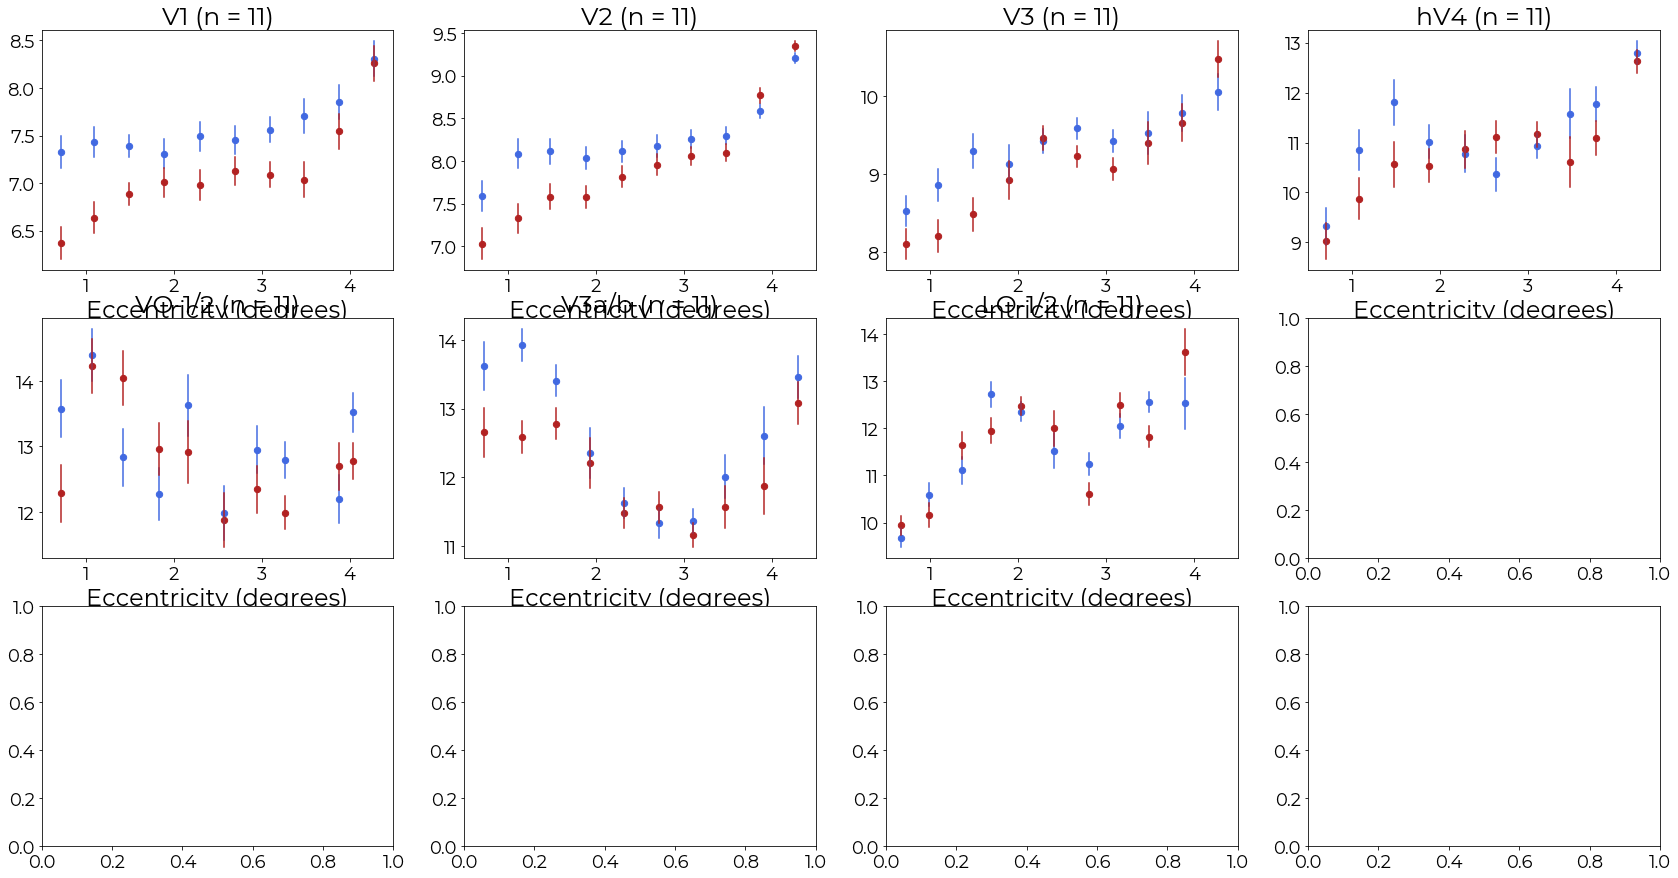

In [346]:
fig, axes = plt.subplots(3,3, figsize=(29, 15))
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 18})
roi_titles = {'V1_vertices': 'V1', 'V2_vertices': 'V2', 'V3_vertices': 'V3', 'hV4_vertices': 'hV4', 'VO_vertices': 'VO-1/2', 'V3AB_vertices': 'V3a/b', 'LO_vertices':'LO-1/2', 'PIPS_vertices':'P-IPS', 'SAIPS_vertices':'SA-IPS'}
for i, roi in enumerate(final_rois):
    print(f'working on {roi}')

    ax = axes[i//3, i%3]
    subavgs_scatter = {sub: np.mean(np.vstack([meandict[sub][roi][condition]['scatter'][f'mean_fwmin'].values for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
    grandavg_scatter = np.mean(np.vstack([meandict[sub][roi][condition]['scatter'][f'mean_fwmin'].values for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

    meandict_scatter_corrected = {sub: {condition: meandict[sub][roi][condition]['scatter'][f'mean_fwmin']-subavgs_scatter[sub]+grandavg_scatter for condition in ['placebo','memantine']} for sub in newsubs}
    
    for index, condition in enumerate(['placebo', 'memantine']):
        mean_ecc_allsubs = np.mean(pd.concat([meandict[sub][roi]['placebo']['scatter']['mean_ecc'] for sub in newsubs], axis=1), axis=1)
        mean_metric_allsubs = np.mean(pd.concat([meandict_scatter_corrected[sub][condition] for sub in newsubs], axis=1), axis=1)

        sem_metric_allsubs = np.std(pd.concat([meandict_scatter_corrected[sub][condition] for sub in newsubs], axis=1), axis=1)/np.sqrt(11)

        ax.scatter(mean_ecc_allsubs, mean_metric_allsubs, color=colorlist[condition], label=condition, s=40)

       # for x, y, sem in zip(mean_ecc_allsubs.values, mean_metric_allsubs.values, sem_metric_allsubs.values):
        for x, y, sem in zip(mean_ecc_allsubs, mean_metric_allsubs, sem_metric_allsubs):
            ax.plot([x, x], [y - sem, y + sem], color=colorlist[condition])
    

    ax.set_xlim([0.5,4.5])
    ax.set_xlabel('Eccentricity (degrees)', fontsize=24)
    ax.set_ylabel('')
    ax.set_title(f'{roi_titles[roi]}', fontsize=25)

fig.suptitle("FWmin metrics for all ROIs")
fig.legend(handles=[placebo_patch, memantine_patch], loc='upper right', ncol=1, fontsize=20)
fig.tight_layout(h_pad=1,w_pad=1, rect=[0,0,0.97,0.97])
save_path = f"/data1/projects/Meman1/projects/pilot/code/kelcey/snellius/images/all_ecc_params_all_rois_exclude_nan.png"
plt.savefig(save_path, dpi = 300)
plt.show()

working on V1_vertices
working on V2_vertices
working on V3_vertices
working on hV4_vertices
working on VO_vertices
working on V3AB_vertices
working on LO_vertices
working on hMT_vertices
working on PIPS_vertices
working on IAIPS_vertices
working on SAIPS_vertices
working on FEF_vertices


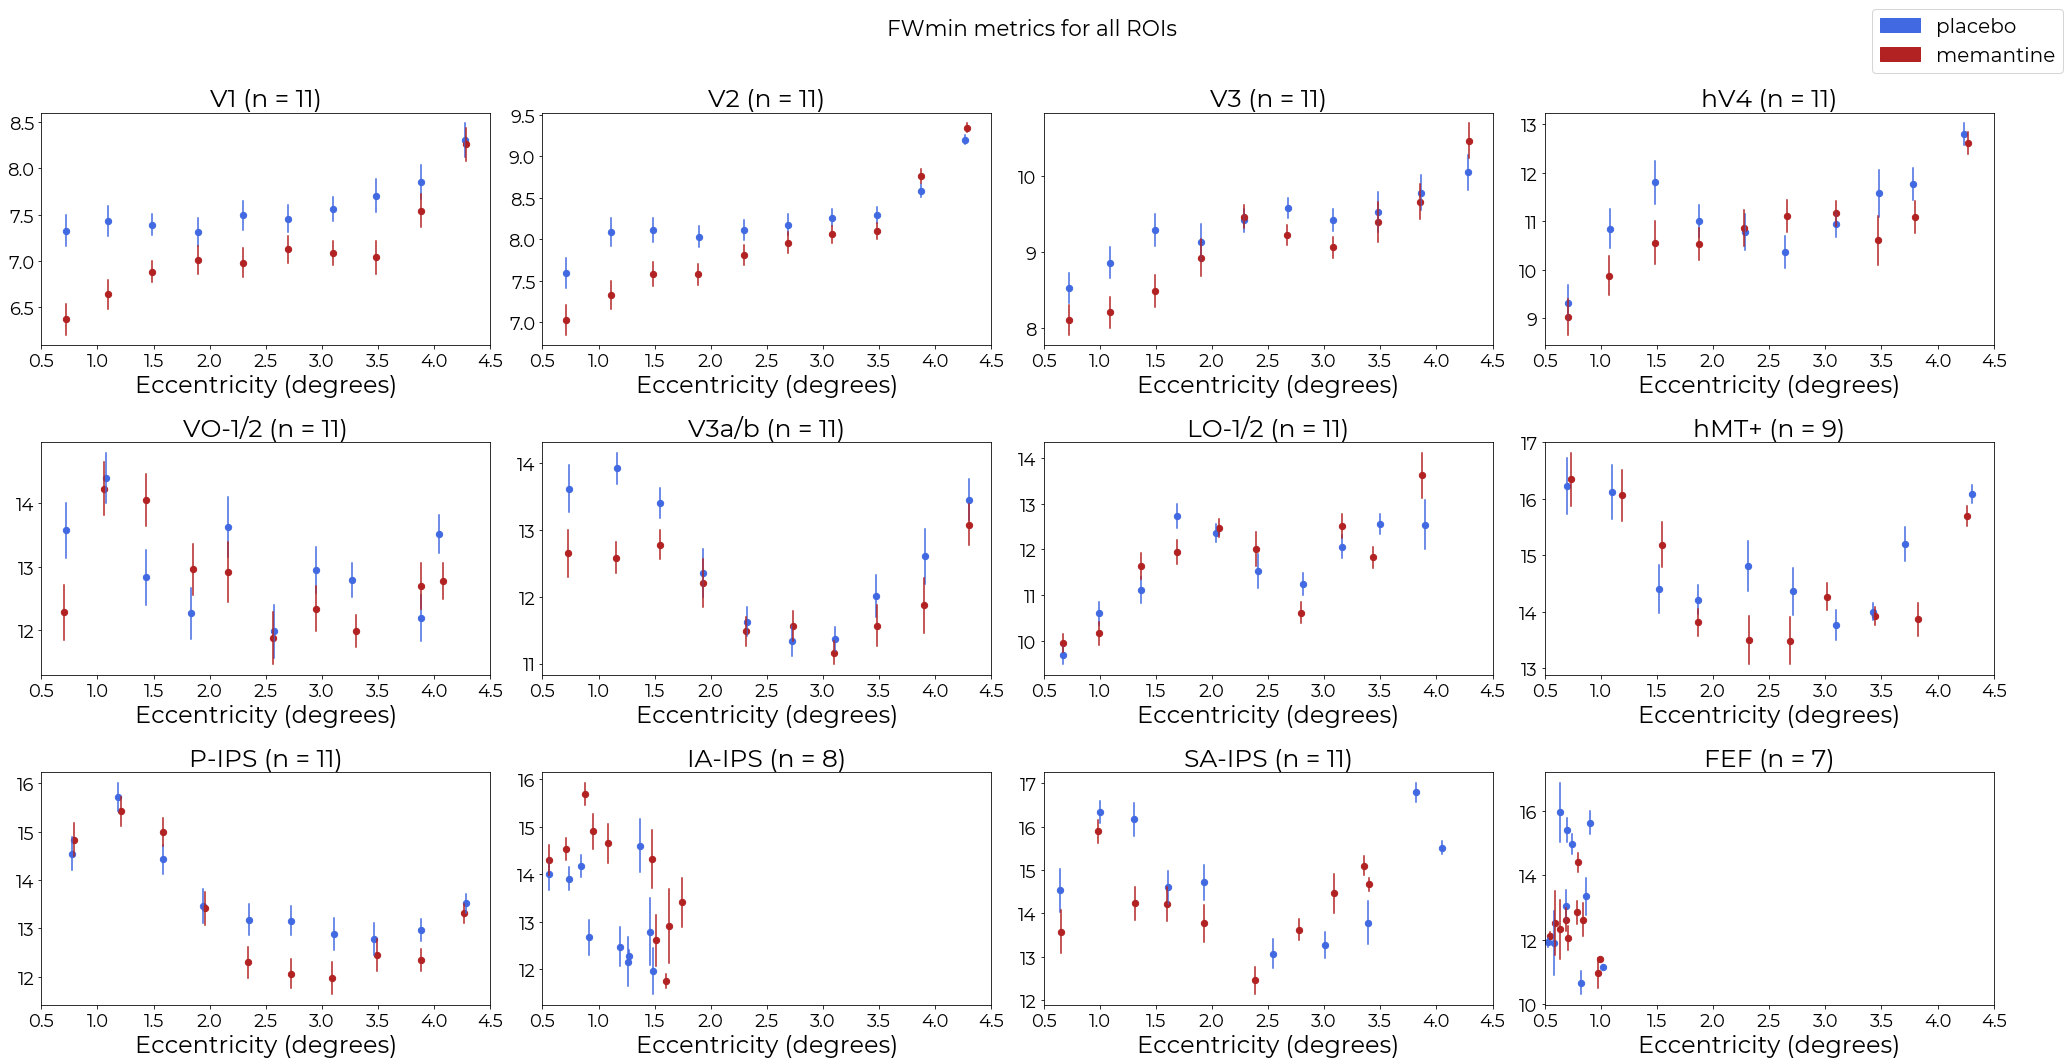

In [351]:
# Adjust the plotting code to check for 'mean_fwmin' and 'mean_ecc' before accessing them
fig, axes = plt.subplots(3, 4, figsize=(29, 15))
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 18})
roi_titles = {'V1_vertices': 'V1 (n = 11)', 'V2_vertices': 'V2 (n = 11)', 'V3_vertices': 'V3 (n = 11)', 
              'hV4_vertices': 'hV4 (n = 11)', 'VO_vertices': 'VO-1/2 (n = 11)', 'V3AB_vertices': 'V3a/b (n = 11)', 
              'LO_vertices': 'LO-1/2 (n = 11)', 'hMT_vertices': 'hMT+ (n = 9)', 'PIPS_vertices': 'P-IPS (n = 11)', 
              'IAIPS_vertices': 'IA-IPS (n = 8)', 'SAIPS_vertices': 'SA-IPS (n = 11)', 'FEF_vertices': 'FEF (n = 7)'}

for i, roi in enumerate(prffits['sub-001']['roi_vertices'].keys()):
    print(f'working on {roi}')

    ax = axes[i // 4, i % 4]

    subavgs_scatter = {
        sub: np.nanmean(
            np.vstack([
                meandict[sub][roi][condition]['scatter'][f'mean_fwmin'] 
                for condition in ['placebo', 'memantine'] 
                if f'mean_fwmin' in meandict[sub][roi][condition]['scatter']
            ]), 
            axis=0
        ) 
        for sub in newsubs if all(f'mean_fwmin' in meandict[sub][roi][condition]['scatter'] for condition in ['placebo', 'memantine'])
    }

    # Only include subjects where 'mean_fwmin' exists in both conditions
    grandavg_scatter = np.nanmean(
        np.vstack([
            meandict[sub][roi][condition]['scatter'][f'mean_fwmin'].values 
            for sub in newsubs 
            for condition in ['placebo', 'memantine'] 
            if f'mean_fwmin' in meandict[sub][roi][condition]['scatter']
        ]), axis=0
    )

    meandict_scatter_corrected = {
        sub: {
            condition: meandict[sub][roi][condition]['scatter'][f'mean_fwmin'] - subavgs_scatter[sub] + grandavg_scatter 
            for condition in ['placebo', 'memantine']
        } 
        for sub in newsubs if f'mean_fwmin' in meandict[sub][roi][condition]['scatter']
    }

    for index, condition in enumerate(['placebo', 'memantine']):
        # Check for 'mean_ecc' before accessing it
        valid_subs = [
            sub for sub in newsubs if f'mean_ecc' in meandict[sub][roi][condition]['scatter']
        ]
        
        if not valid_subs:
            print(f"No mean_ecc data available for {roi} in {condition}. Skipping...")
            continue

        mean_ecc_allsubs = np.nanmean(
            pd.concat([meandict[sub][roi][condition]['scatter']['mean_ecc'] for sub in valid_subs], axis=1), axis=1
        )
        mean_metric_allsubs = np.nanmean(
            pd.concat([meandict_scatter_corrected[sub][condition] for sub in valid_subs], axis=1), axis=1
        )

        sem_metric_allsubs = np.nanstd(
            pd.concat([meandict_scatter_corrected[sub][condition] for sub in valid_subs], axis=1), axis=1
        ) / np.sqrt(len(valid_subs))

        ax.scatter(mean_ecc_allsubs, mean_metric_allsubs, color=colorlist[condition], label=condition, s=40)

        for x, y, sem in zip(mean_ecc_allsubs, mean_metric_allsubs, sem_metric_allsubs):
            ax.plot([x, x], [y - sem, y + sem], color=colorlist[condition])

    ax.set_xlim([0.5, 4.5])
    ax.set_xlabel('Eccentricity (degrees)', fontsize=24)
    ax.set_ylabel('')
    ax.set_title(f'{roi_titles[roi]}', fontsize=25)

fig.suptitle("FWmin metrics for all ROIs")
fig.legend(handles=[placebo_patch, memantine_patch], loc='upper right', ncol=1, fontsize=20)
fig.tight_layout(h_pad=1, w_pad=1, rect=[0, 0, 0.97, 0.97])
save_path = f"/data1/projects/Meman1/projects/pilot/code/kelcey/snellius/images/all_ecc_params_all_rois_exclude_nan.png"
plt.savefig(save_path, dpi=300)
plt.show()


In [161]:
for sub in newsubs:
    print(sub)
    if sub in ['sub-001', 'sub-008']:
        continue
    print(meandict[sub][roi][condition]['scatter']['mean_fwmin'])
   

sub-001
sub-002
eccentricity_bin
0    11.615808
1          NaN
2          NaN
3          NaN
4    14.617309
5          NaN
6     9.314657
7    16.238119
8          NaN
9    12.216108
dtype: float64
sub-003
eccentricity_bin
0     7.833917
1    14.977489
2     7.233617
3    11.375688
4    11.655828
5     8.214108
6    11.955978
7    11.975988
8    11.175588
9    10.875438
dtype: float64
sub-004
eccentricity_bin
0    15.397698
1    13.636819
2    15.937969
3    14.417209
4    13.956979
5    17.798899
6    15.157578
7    10.955478
8          NaN
9          NaN
dtype: float64
sub-005
eccentricity_bin
0    11.615808
1    10.315158
2    10.995498
3    10.475238
4    10.215108
5    13.596798
6    13.656829
7    11.375688
8    10.215108
9     9.614807
dtype: float64
sub-007
eccentricity_bin
0    13.536768
1    11.135568
2    15.157578
3    14.237119
4    10.435218
5    16.198099
6          NaN
7    11.575788
8    14.237119
9    10.995498
dtype: float64
sub-008
sub-010
eccentricity_bin
0    13.0

KeyError: 'mean_fwmin'

In [355]:
# Define a dictionary to store t-statistics and p-values for each metric
results_dict = {roi: [] for roi in prffits['sub-001']['roi_vertices'].keys()} # Define a dictionary to store t-statistics and p-values for each metric
# Significance threshold (e.g., 0.05)
alpha = 0.05

# Display eccentricity bin ranges
eccentricity_ranges = [(round(bin_edges[i], 3), round(bin_edges[i+1], 3)) for i in range(num_bins)]

# Loop through each metric and perform paired t-tests for each bin
for i, roi in enumerate(prffits['sub-001']['roi_vertices'].keys()):
    if roi in ['hMT_vertices', 'IAIPS_vertices', 'FEF_vertices']:
        print(f'{roi} cannot be statistically tested and do not have time to fix rn')
        continue
    print(f"Performing paired t-tests for {roi}")
    
    # For each metric, iterate over all bins
    for bin_index in range(num_bins):
        placebo_bin = []
        memantine_bin = []

        # Collect data for each bin across all subjects
        for sub in newsubs:
            try:
                # Get the data for the current bin for both placebo and memantine for the current subject
                placebo_bin.append(meandict[sub][roi]['placebo']['scatter'][f'mean_fwmin'].values[bin_index])
                memantine_bin.append(meandict[sub][roi]['memantine']['scatter'][f'mean_fwmin'].values[bin_index])
            except IndexError:
                # In case there are missing data for some subjects, handle it appropriately
                print(f"Data missing for {sub} in bin {bin_index}, skipping...")

        # Perform the paired t-test for the current bin (if data exists)
        if len(placebo_bin) > 0 and len(memantine_bin) > 0:
            t_stat, p_value = ttest_rel(placebo_bin, memantine_bin, nan_policy='propagate')  # do not ignore NaNs
            results_dict[roi].append((eccentricity_ranges[bin_index], round(t_stat, 3), round(p_value, 3), p_value < alpha))
        else:
            results_dict[roi].append((eccentricity_ranges[bin_index], np.nan, np.nan, False))  # Append NaN if no data is available for the bin

    # Print the results with eccentricity ranges, t-statistics, p-values, and significance flag
    print(f"Results for fwmin:")
    for ecc_range, t_stat, p_val, is_significant in results_dict[roi]:
        sig_marker = "***" if is_significant else ""  # Mark significant values
        print(f"{ecc_range}: t-statistic = {t_stat}, p-value = {p_val} {sig_marker}")



Performing paired t-tests for V1_vertices
Results for fwmin:
(0.5, 0.9): t-statistic = 2.726, p-value = 0.021 ***
(0.9, 1.3): t-statistic = 2.374, p-value = 0.039 ***
(1.3, 1.7): t-statistic = 2.086, p-value = 0.064 
(1.7, 2.1): t-statistic = 0.939, p-value = 0.37 
(2.1, 2.5): t-statistic = 1.555, p-value = 0.151 
(2.5, 2.9): t-statistic = 1.076, p-value = 0.307 
(2.9, 3.3): t-statistic = 1.717, p-value = 0.117 
(3.3, 3.7): t-statistic = 1.764, p-value = 0.108 
(3.7, 4.1): t-statistic = 0.808, p-value = 0.438 
(4.1, 4.5): t-statistic = 0.129, p-value = 0.9 
Performing paired t-tests for V2_vertices
Results for fwmin:
(0.5, 0.9): t-statistic = 1.473, p-value = 0.171 
(0.9, 1.3): t-statistic = 2.122, p-value = 0.06 
(1.3, 1.7): t-statistic = 1.714, p-value = 0.117 
(1.7, 2.1): t-statistic = 1.684, p-value = 0.123 
(2.1, 2.5): t-statistic = 1.177, p-value = 0.267 
(2.5, 2.9): t-statistic = 0.827, p-value = 0.427 
(2.9, 3.3): t-statistic = 0.919, p-value = 0.38 
(3.3, 3.7): t-statistic = 0

In [356]:
##Predicted response to significant ecc 
significant_roi = ['V3AB_vertices', 'SAIPS_vertices']
meandict_temporal = {sub: {roi: {condition: {'prediction': {}, 'bold': {}, 'hrf': {}} for condition in ['placebo', 'memantine']} for roi in significant_roi} for sub in newsubs}

for index, sub in enumerate(newsubs):
    print("working on",  sub)
    for roi in significant_roi:
        if roi in ['V3AB_vertices']:
            ecc_range = [1.3, 1.7]
        else:
            ecc_range = [0.9, 1.3]
        # Collect valid vertices for both conditions
        valid_vertices_shared = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if 
                                    vertex in prffits[sub]['fits']['placebo'].params.index and 
                                    vertex in prffits[sub]['fits']['memantine'].params.index and
                                    (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2'] >= 0.3 and 
                                    prffits[sub]['fits']['memantine'].params.loc[vertex]['r2'] >= 0.3)]

        for i, condition in enumerate(['placebo', 'memantine']):
            models = prffits[sub]['fits'][condition].pRFmodelFitting  
            models.norm_model.stimulus = prf_stim
            params_valid = prffits[sub]['fits'][condition].params.loc[valid_vertices_shared]

            # Filter vertices based on eccentricity
            valid_vertices_shared_lowecc = params_valid[(params_valid['ecc'] >= ecc_range[0]) & (params_valid['ecc'] <= ecc_range[1])].index
            params_valid_lowecc = models.norm_iter[valid_vertices_shared_lowecc, ...]

            #################### FIRST, CALCULATE PREDICTED TIME COURSES ###############
            # Vectorized time course calculation if possible
            timecourses = np.array([timecourse_at_zero(models, row) for row in params_valid_lowecc])
            timecourses_array = timecourses.reshape(timecourses.shape[0], 35)
            print(timecourses_array.shape)

            # Optimized weighted mean and CI calculation
            mean, std, sem, ci = get_mean_profile(timecourses_array, weighted=True, weights=params_valid_lowecc[:, -1])
            meandict_temporal[sub][roi][condition]['prediction']['mean'] = mean
            meandict_temporal[sub][roi][condition]['prediction']['ci'] = ci

        

working on sub-001


KeyError: 'placebo'

In [359]:
##Predicted response to significant ecc 
significant_roi = ['V3AB_vertices', 'SAIPS_vertices']
meandict_temporal = {sub: {roi: {condition: {'prediction': {}, 'bold': {}, 'hrf': {}} for condition in ['placebo', 'memantine']} for roi in significant_roi} for sub in newsubs}

for index, sub in enumerate(newsubs):
    print("working on",  sub)
    for roi in significant_roi:
        if roi in ['V3AB_vertices']:
            ecc_range = [1.3, 1.7]
        else:
            ecc_range = [0.9, 1.3]
        # Collect valid vertices for both conditions
        valid_vertices_shared = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if 
                                    vertex in prffits[sub]['fits']['placebo'].params.index and 
                                    vertex in prffits[sub]['fits']['memantine'].params.index and
                                    (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2'] >= 0.3 and 
                                    prffits[sub]['fits']['memantine'].params.loc[vertex]['r2'] >= 0.3)]

        for i, condition in enumerate(['placebo', 'memantine']):
            models = prffits[sub]['fits'][condition].pRFmodelFitting  
            models.norm_model.stimulus = prf_stim2
            params_valid = prffits[sub]['fits'][condition].params.loc[valid_vertices_shared]

            # Filter vertices based on eccentricity
            valid_vertices_shared_lowecc = params_valid[(params_valid['ecc'] >= ecc_range[0]) & (params_valid['ecc'] <= ecc_range[1])].index
            params_valid_lowecc = models.norm_iter[valid_vertices_shared_lowecc, ...]

            #################### FIRST, CALCULATE PREDICTED TIME COURSES ###############

        
            # Vectorized time course calculation if possible
            timecourses = np.array([timecourse_at_zero(models, row) for row in params_valid_lowecc])
            timecourses = np.squeeze(timecourses)
            #All barpasses
            timecourses_array_1 = timecourses[:, 15:35]
            timecourses_array_2 = timecourses[:, 35:55]
            timecourses_array_3 = timecourses[:, 70:90]
            timecourses_array_4 = timecourses[:, 90:110]
            timecourses_array_5 = timecourses[:, 125:145]
            timecourses_array_6 = timecourses[:, 145:165]
            timecourses_array_7 = timecourses[:, 180:200]
            timecourses_array_8 = timecourses[:, 200:220]
            timecourse_arrays = [timecourses_array_1, timecourses_array_2, timecourses_array_3, timecourses_array_4, timecourses_array_5, timecourses_array_6, timecourses_array_7, timecourses_array_8]
            aligned_arrays = []

            # Get the length of each array (assumes they are of equal length)
            array_length = timecourses_array_1.shape[1]  # Assuming all arrays are the same size

            # The center index of each array (where we want the max to be centered)
            center_index = array_length // 2  # This is the center

            # Step 1: Find max index for each array and shift
            for array in timecourse_arrays:
                # Find the index of the max value
                max_index = np.argmax(np.mean(array, axis=0))  # Find max along time axis
                
                # Step 2: Shift array to center the max
                shift_amount = center_index - max_index
                aligned_array = np.roll(array, shift_amount, axis=1)  # Shift along the time axis
                
                # Add aligned array to the list
                aligned_arrays.append(aligned_array)

            # Step 3: Compute the average across the 8 aligned arrays
            aligned_arrays_stack = np.vstack(aligned_arrays)  # Stack them vertically
            # Make sure weights correspond to the number of profiles in aligned_arrays_stack
            n_profiles = aligned_arrays_stack.shape[0] // 8  # Assuming 8 time courses are stacked
            weights_prediction = np.repeat(params_valid_lowecc[:n_profiles, -1], 8)  # Repeat each weight for the 8 arrays

            # Now pass this corrected weight array to the function
            mean, std, sem, ci = get_mean_profile(aligned_arrays_stack, weighted=True, weights=weights_prediction)
            meandict_temporal[sub][roi][condition]['prediction']['mean'] = mean
            meandict_temporal[sub][roi][condition]['prediction']['ci'] = ci

        

working on sub-001
working on sub-002
working on sub-003
working on sub-004
working on sub-005
working on sub-007
working on sub-008
working on sub-010
working on sub-012
working on sub-013
working on sub-016


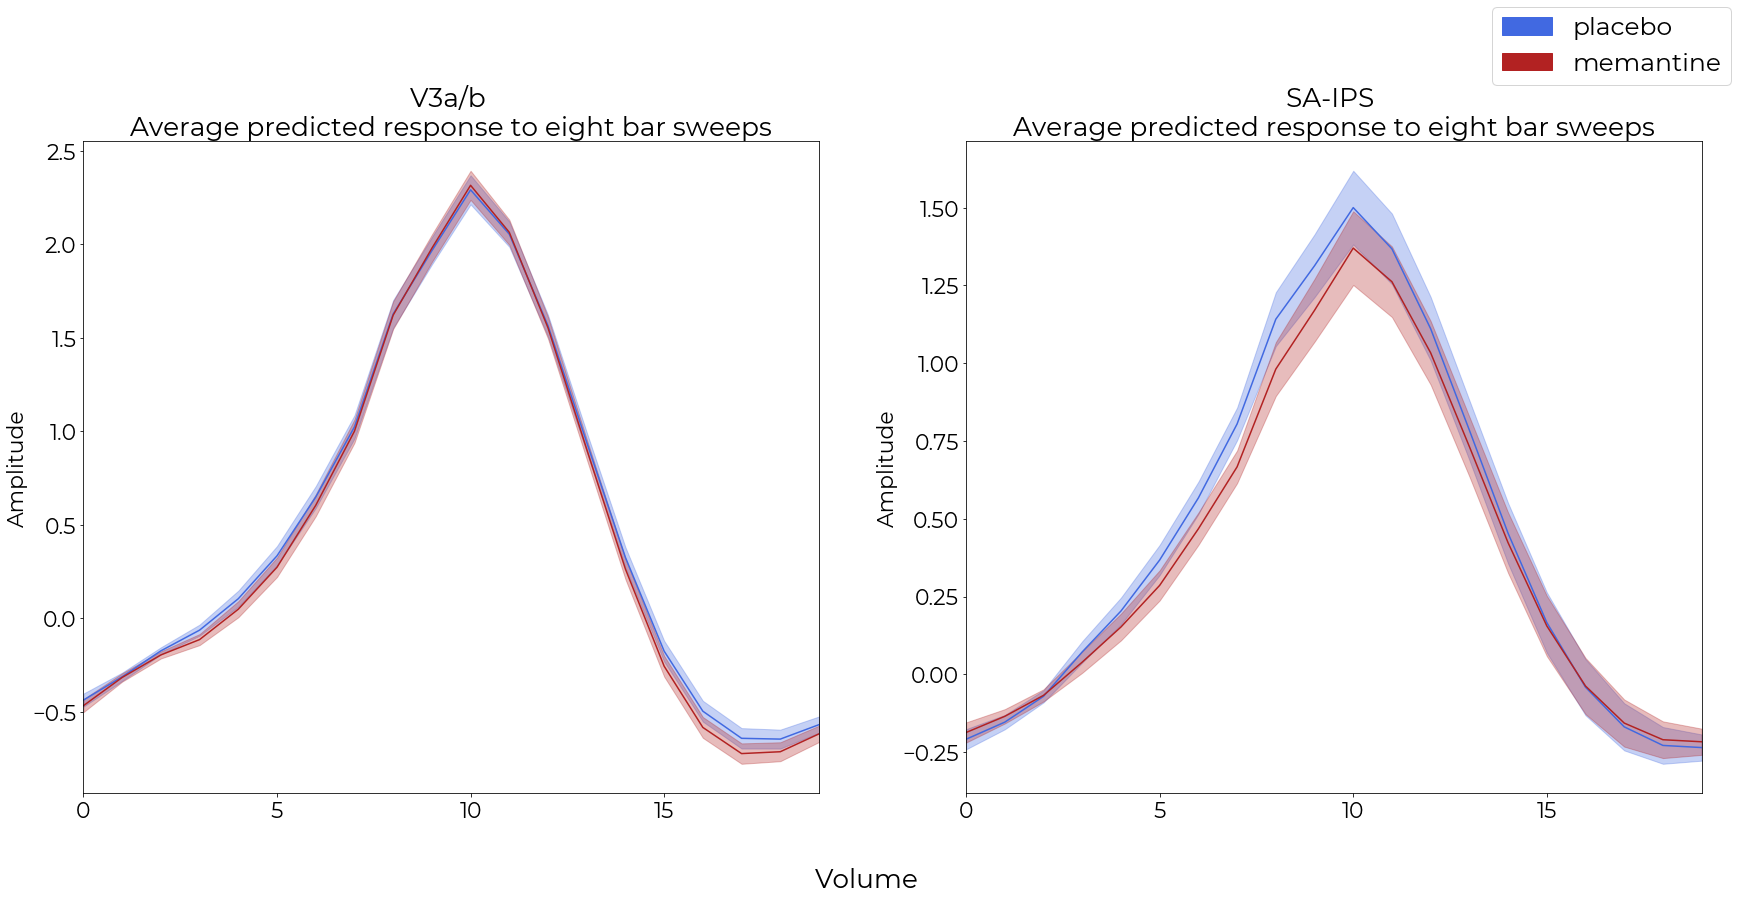

In [372]:
fig, axes = plt.subplots(1,2, figsize=(29, 12), sharex='col')
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 22})
sigroi_title = {'V3AB_vertices': 'V3a/b', 'SAIPS_vertices': 'SA-IPS'}
for i, roi in enumerate(significant_roi):


    ################# PANEL B: PREDICTED TIME COURSE ########################
    subavgs = {sub: np.mean(np.vstack([meandict_temporal[sub][roi][condition]['prediction']['mean'] for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
    grandavg = np.mean(np.vstack([meandict_temporal[sub][roi][condition]['prediction']['mean'] for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

    meandict_temporal_corrected = {sub: {condition: meandict_temporal[sub][roi][condition]['prediction']['mean']-subavgs[sub]+grandavg for condition in ['placebo','memantine']} for sub in newsubs}

    for index, condition in enumerate(['placebo', 'memantine']):
        mean_allsubs = np.mean(np.vstack([meandict_temporal[sub][roi][condition]['prediction']['mean'] for sub in newsubs]), axis=0)

        sem_allsubs = np.std(np.vstack([meandict_temporal_corrected[sub][condition] for sub in newsubs]), axis=0)/np.sqrt(len(newsubs))

        ci_allsubs = 1.96*sem_allsubs

        axes[i].plot(mean_allsubs, color = colorlist[condition])
        axes[i].fill_between(range(20), mean_allsubs-ci_allsubs, mean_allsubs+ci_allsubs, color = colorlist[condition], alpha=0.3)

    axes[i].set_xlim(0,19)
    axes[i].set_title(f'{sigroi_title[roi]} \nAverage predicted response to eight bar sweeps')

    axes[i].set_ylabel('Amplitude')
    axes[i].set_xticks(range(0,19,5), range(0,19,5))

fig.legend(handles=[placebo_patch, memantine_patch], ncol=1, fontsize=25, bbox_to_anchor=(0.92,1.05))
fig.supxlabel('Volume')
save_path = f"/data1/projects/Meman1/projects/pilot/code/kelcey/snellius/images/sig_roi_temporalsuppression_midecc_withoutBOLD_average.png"

plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

In [371]:
##look at fwmin for ALL rois 
# Characteristics of eccentricity bins for all parameters over 10 bins 
num_bins=10
# Calculate the necessary metrics for all the subjects and saving them
metric = 'fwmin'
meandict = {
    sub: {
        roi: {
            condition: {
                'scatter': {},
                'profile': {'mean': {}, 'ci': {}},
                'profile_absolute': {'mean': {}, 'ci':{}},
                'bar': {}
            }
            for condition in ['placebo', 'memantine']
        }
        for roi in significant_roi
    } | {'difference': {}}
    for sub in conditions.keys()
}

ecc_range = [0.5, 2.0]

# Plot 1: Metric versus Eccentricity in both conditions

for index, sub in enumerate(conditions.keys()):

    if sub == 'sub-015':
        print('sub-015 has technical issues, skipping..')
        continue
    print(f'working on {sub}')

    for roi in significant_roi:
        # if roi in ['V3AB_vertices']:
        #     ecc_range = [1.3, 1.7]
        # else:
        #     ecc_range = [0.9, 1.3]
        print(f'working on {roi}')
        valid_vertices_V1_plac = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if vertex in prffits[sub]['fits']['placebo'].params.index]
        valid_vertices_V1_mem = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if vertex in prffits[sub]['fits']['memantine'].params.index]

        # Only select vertices that had r2>0.3 for at least one of the conditions
        valid_vertices_V1_shared = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if 
                                    vertex in prffits[sub]['fits']['placebo'].params.index and 
                                    vertex in prffits[sub]['fits']['memantine'].params.index and
                                    (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>=0.3 and 
                                    prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>=0.3)]
        print(len(valid_vertices_V1_mem), len(valid_vertices_V1_shared))
        for index, condition in enumerate(['placebo', 'memantine']):

            ############## 2. CALCULATE ECCENTRICITY VS METRIC PER CONDITION  ###################

            shapemetrics_V1 = prffits[sub]['fits'][condition].params.loc[valid_vertices_V1_shared].dropna(subset=metric)
            ############## 4. CALCULATE PROFILES FOR SIGNIFICANT ECC  ###################

            shapemetrics_significant = shapemetrics_V1[(shapemetrics_V1['ecc'] >= ecc_range[0]) & (shapemetrics_V1['ecc'] <= ecc_range[1])]
            allprofiles_significant = {'vertex': [],'r2': [],'profile': [], 'profile_absolute': []}
            
            for row in shapemetrics_significant.iterrows():
                profile = profile_fwhm_fwmin(row[1],normalizeprofile=normalize_profiles)
                profile_absolute = profile_fwhm_fwmin(row[1],normalizeprofile=False)
                print(profile.size)
                if profile.size != 0:
                    allprofiles_significant['vertex'].append(row[0])
                    allprofiles_significant['r2'].append(shapemetrics_significant.loc[row[0]]['r2'])
                    allprofiles_significant['profile'].append(profile)
                    allprofiles_significant['profile_absolute'].append(profile_absolute)


            # Calculate mean

            mean_significant,_,_,ci_significant = get_mean_profile(np.vstack(allprofiles_significant['profile']), weighted=True, weights=allprofiles_significant['r2'])
            mean_significant_absolute,_,_,ci_significant_absolute = get_mean_profile(np.vstack(allprofiles_significant['profile_absolute']), weighted=True, weights=allprofiles_significant['r2'])
    

            meandict[sub][roi][condition]['profile']['mean'][f'{ecc_range[0]}-{ecc_range[1]}'] = mean_significant
            meandict[sub][roi][condition]['profile']['ci'][f'{ecc_range[0]}-{ecc_range[1]}'] = ci_significant

            meandict[sub][roi][condition]['profile_absolute']['mean'][f'{ecc_range[0]}-{ecc_range[1]}'] = mean_significant_absolute
            meandict[sub][roi][condition]['profile_absolute']['ci'][f'{ecc_range[0]}-{ecc_range[1]}'] = ci_significant_absolute

working on sub-001
working on V3AB_vertices
834 754
               x         y  prf_size   prf_ampl      bold_bsl  surr_ampl  \
12      0.404730 -1.808147  1.190777  24.800985 -7.110046e-20   5.796500   
18      0.491569 -1.845092  1.280320  30.458150 -1.619618e-18   5.550339   
24      0.583212 -1.770980  1.062167  66.722983 -1.004342e-20   8.995448   
2046    1.272048  1.380124  1.820828   0.026054 -8.063945e-30   0.002852   
2050    1.394681  1.321729  1.545728   0.103102  2.444728e-40   0.016584   
2444    1.343950  1.365555  1.820030   0.040156  6.803697e-46   0.004142   
2445    1.315964  1.409215  2.009988   0.022117 -7.853605e-53   0.001778   
2453    1.274313  1.284517  1.731519   0.062685  3.542804e-48   0.007099   
2454    1.233800  1.317004  2.038157   0.029361  4.254037e-73   0.002331   
2455    1.286893  1.372751  1.615005   4.829696 -3.093633e-22   0.531618   
2854    1.356783  1.399702  1.658982   0.619875 -3.024380e-31   0.082696   
2860    1.341614  1.370487  1.812601

KeyboardInterrupt: 

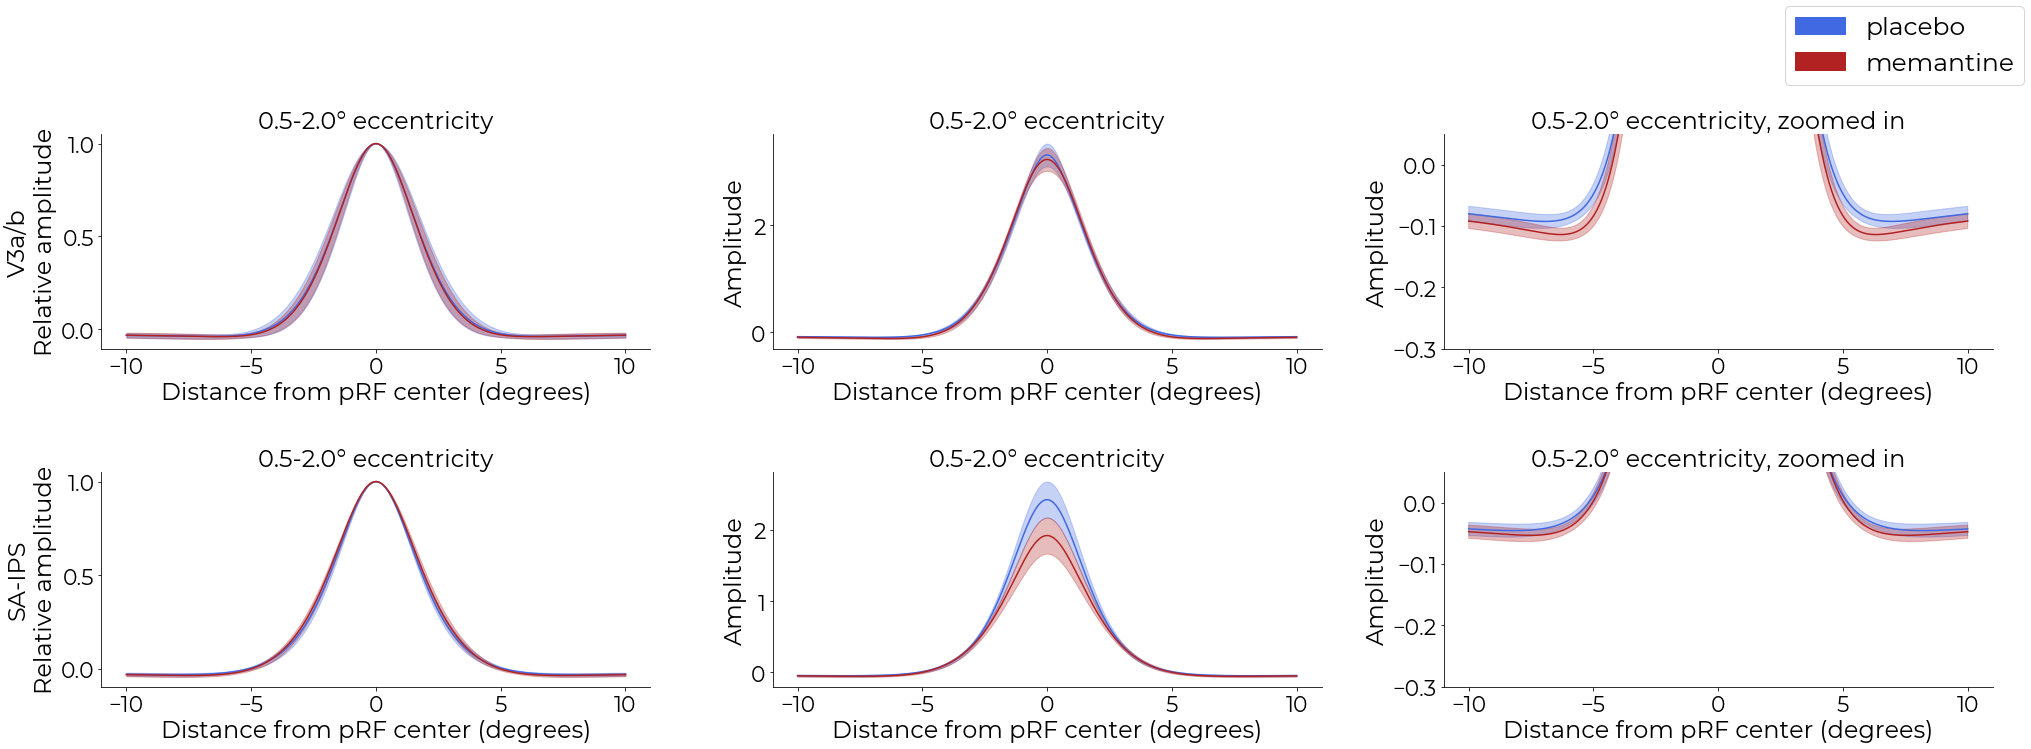

In [241]:
colorlist = {'placebo':'royalblue','memantine':'firebrick'}
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 22})

# Create the figure
fig, axes = plt.subplots(2,3, figsize=(29, 10))

######### PROFILE PANELS #########
for index, roi in enumerate(significant_roi):

    for jndex, ecc in enumerate(['0.5-2.0']):

        subavgs = {sub: np.mean(np.vstack([meandict[sub][roi][condition]['profile']['mean'][ecc] for condition in ['placebo','memantine']]), axis=0) for roi in significant_roi for sub in newsubs}
        grandavg = np.mean(np.vstack([meandict[sub][roi][condition]['profile']['mean'][ecc] for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

        meandict_corrected = {sub: {condition: meandict[sub][roi][condition]['profile']['mean'][ecc]-subavgs[sub]+grandavg for condition in ['placebo','memantine']} for sub in newsubs}
            
        for condition in ['placebo', 'memantine']:
            mean_allsubs = np.mean(np.vstack([meandict[sub][roi][condition]['profile']['mean'][ecc] for sub in newsubs]), axis=0)

            sem_allsubs = np.std(np.vstack([meandict_corrected[sub][condition] for sub in newsubs]), axis=0)/np.sqrt(11)

            ci_allsubs = 1.96*sem_allsubs

            axes[index, jndex].plot(np.linspace(-10,10, 2000), mean_allsubs, color = colorlist[condition])
            axes[index, jndex].fill_between(np.linspace(-10,10, 2000), mean_allsubs-ci_allsubs, mean_allsubs+ci_allsubs, color = colorlist[condition], alpha=0.3)

            axes[index, jndex].set_xlabel('Distance from pRF center (degrees)', fontsize=24)
            axes[index, jndex].set_ylabel(f'{sigroi_title[roi]}\nRelative amplitude', fontsize=24)
            axes[index, jndex].set_title(f'{ecc}° eccentricity', fontsize=24)

    for jndex, ecc in enumerate(['0.5-2.0']):

        subavgs_abs = {sub: np.mean(np.vstack([meandict[sub][roi][condition]['profile_absolute']['mean'][ecc] for condition in ['placebo','memantine']]), axis=0) for sub in newsubs}
        grandavg_abs = np.mean(np.vstack([meandict[sub][roi][condition]['profile_absolute']['mean'][ecc] for sub in newsubs for condition in ['placebo','memantine']]), axis=0)

        meandict_corrected = {sub: {condition: meandict[sub][roi][condition]['profile_absolute']['mean'][ecc]-subavgs_abs[sub]+grandavg_abs for condition in ['placebo','memantine']} for sub in newsubs}
            
        for condition in ['placebo', 'memantine']:
            mean_allsubs_abs = np.mean(np.vstack([meandict[sub][roi][condition]['profile_absolute']['mean'][ecc] for sub in newsubs]), axis=0)

            sem_allsubs_abs = np.std(np.vstack([meandict_corrected[sub][condition] for sub in newsubs]), axis=0)/np.sqrt(len(newsubs))

            ci_allsubs_abs = 1.96*sem_allsubs_abs

            axes[index, 1 +jndex].plot(np.linspace(-10,10, 2000), mean_allsubs_abs, color = colorlist[condition])
            axes[index, 1 +jndex].fill_between(np.linspace(-10,10, 2000), mean_allsubs_abs-ci_allsubs_abs, mean_allsubs_abs+ci_allsubs_abs, color = colorlist[condition], alpha=0.3)


            axes[index, 1 +jndex].set_xlabel('Distance from pRF center (degrees)', fontsize=24)
            axes[index, 1 +jndex].set_ylabel('Amplitude', fontsize=24)
            axes[index, 1 +jndex].set_title(f'{ecc}° eccentricity', fontsize=24)

            #Zoomed in the surround 
            axes[index, 2 +jndex].plot(np.linspace(-10,10, 2000), mean_allsubs_abs, color = colorlist[condition])
            axes[index, 2 +jndex].fill_between(np.linspace(-10,10, 2000), mean_allsubs_abs-ci_allsubs_abs, mean_allsubs_abs+ci_allsubs_abs, color = colorlist[condition], alpha=0.3)

            axes[index, 2 +jndex].set_ylim(-0.3, 0.05)
            axes[index, 2 +jndex].set_xlabel('Distance from pRF center (degrees)', fontsize=24)
            axes[index, 2 +jndex].set_ylabel('Amplitude', fontsize=24)
            axes[index, 2 +jndex].set_title(f'{ecc}° eccentricity, zoomed in', fontsize=24)
sns.despine()
# Adjust the layout
plt.tight_layout(pad=2.0)
fig.legend(handles=[placebo_patch, memantine_patch], ncol=1, fontsize=25, bbox_to_anchor=(1,1.1))
save_path = f"/data1/projects/Meman1/projects/pilot/code/kelcey/snellius/images/sigroi_profiles_significant.png"
# Display the plot

plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

In [262]:
dfs = []

# Loop through all subjects and ROIs
for sub in newsubs:
    print("Working on", sub)

    # Loop through each ROI
    for roi in prffits[sub]['roi_vertices'].keys():
        print(f"Processing ROI: {roi}")
        
        # Get valid vertices for placebo and memantine conditions
        valid_vertices_plac = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if vertex in prffits[sub]['fits']['placebo'].params.index]
        valid_vertices_mem = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if vertex in prffits[sub]['fits']['memantine'].params.index]

        # Select vertices that have valid r2 values in both conditions
        valid_vertices_shared = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if
                                 vertex in prffits[sub]['fits']['placebo'].params.index and
                                 vertex in prffits[sub]['fits']['memantine'].params.index and
                                 (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2'] > 0.1 and
                                  prffits[sub]['fits']['memantine'].params.loc[vertex]['r2'] > 0.1)]
        
        # Loop through conditions and process the data
        for condition in ['placebo', 'memantine']:
            filtered_params = prffits[sub]['fits'][condition].params.loc[valid_vertices_shared]

            # For the eccentricity range 0.5-4.5
            ecc_range = (0.5, 4.5)
            filtered_params_ecc = filtered_params.loc[(filtered_params['ecc'] > ecc_range[0]) & (filtered_params['ecc'] < ecc_range[1])]

            # Calculate the mean metric
            mean_metric, _, _ = get_descriptives(filtered_params_ecc, 'min/max', weighted=True)

            # Store the data
            data = {
                'sub': sub,
                'roi': roi,
                'condition': condition,
                'eccentricity': f'{ecc_range[0]}-{ecc_range[1]}',
                'minmax': mean_metric
            }
            dfs.append(data)

# Convert the list of dictionaries into a DataFrame
mean_metric_df = pd.DataFrame(dfs)

Working on sub-001
Processing ROI: V1_vertices
Processing ROI: V2_vertices
Processing ROI: V3_vertices
Processing ROI: hV4_vertices
Processing ROI: VO_vertices
Processing ROI: V3AB_vertices
Processing ROI: LO_vertices
Processing ROI: hMT_vertices
Processing ROI: PIPS_vertices
Processing ROI: IAIPS_vertices
Processing ROI: SAIPS_vertices
Processing ROI: FEF_vertices
Working on sub-002
Processing ROI: V1_vertices
Processing ROI: V2_vertices
Processing ROI: V3_vertices
Processing ROI: hV4_vertices
Processing ROI: VO_vertices
Processing ROI: V3AB_vertices
Processing ROI: LO_vertices
Processing ROI: hMT_vertices
Processing ROI: PIPS_vertices
Processing ROI: IAIPS_vertices
Processing ROI: SAIPS_vertices
Processing ROI: FEF_vertices
Working on sub-003
Processing ROI: V1_vertices
Processing ROI: V2_vertices
Processing ROI: V3_vertices
Processing ROI: hV4_vertices
Processing ROI: VO_vertices
Processing ROI: V3AB_vertices
Processing ROI: LO_vertices
Processing ROI: hMT_vertices
Processing ROI: P

KeyboardInterrupt: 

In [269]:
dfs = []
for sub in newsubs:
    print("Working on", sub)

    # Loop through each ROI
    for roi in significant_roi:
        print(f"Processing ROI: {roi}")
        
        valid_vertices_shared = [vertex for vertex in prffits[sub]['roi_vertices'][roi] if 
                                    vertex in prffits[sub]['fits']['placebo'].params.index and 
                                    vertex in prffits[sub]['fits']['memantine'].params.index and
                                    (prffits[sub]['fits']['placebo'].params.loc[vertex]['r2']>=0.3 and 
                                    prffits[sub]['fits']['memantine'].params.loc[vertex]['r2']>=0.3)]
        
        for condition in ['placebo','memantine']:
            filtered_params = prffits[sub]['fits'][condition].params.loc[valid_vertices_shared]
            
            for ecc_range in [(0.5,2.0)]:                   
                filtered_params_ecc = filtered_params.loc[(filtered_params['ecc']>ecc_range[0]) & (filtered_params['ecc']<ecc_range[1])]
                
                mean_metric,_,_ = get_descriptives(filtered_params_ecc, 'min/max',weighted=True)

                data = {'sub':sub,
                        'roi': roi,
                        'condition':condition,
                        'eccentricity':f'{str(ecc_range[0])}-{str(ecc_range[1])}', 
                        'minmax': mean_metric}
                
                dfs.append(data)
                
    mean_metric_df = pd.DataFrame(dfs)

Working on sub-001
Processing ROI: V3AB_vertices
Processing ROI: SAIPS_vertices
Working on sub-002
Processing ROI: V3AB_vertices
Processing ROI: SAIPS_vertices
Working on sub-003
Processing ROI: V3AB_vertices
Processing ROI: SAIPS_vertices
Working on sub-004
Processing ROI: V3AB_vertices
Processing ROI: SAIPS_vertices
Working on sub-005
Processing ROI: V3AB_vertices
Processing ROI: SAIPS_vertices
Working on sub-007
Processing ROI: V3AB_vertices
Processing ROI: SAIPS_vertices
Working on sub-008
Processing ROI: V3AB_vertices
Processing ROI: SAIPS_vertices
Working on sub-010
Processing ROI: V3AB_vertices
Processing ROI: SAIPS_vertices
Working on sub-012
Processing ROI: V3AB_vertices
Processing ROI: SAIPS_vertices
Working on sub-013
Processing ROI: V3AB_vertices
Processing ROI: SAIPS_vertices
Working on sub-016
Processing ROI: V3AB_vertices
Processing ROI: SAIPS_vertices


In [271]:
# Get the unique eccentricity ranges from the DataFrame
eccentricity_ranges = mean_metric_df['eccentricity'].unique()

# Loop through each eccentricity bin
for roi in significant_roi:
    # Get the placebo values for this ROI
    placebo_values = mean_metric_df.loc[(mean_metric_df['condition'] == 'placebo') & 
                                        (mean_metric_df['roi'] == roi)]['minmax']
    
    # Get the memantine values for this ROI
    memantine_values = mean_metric_df.loc[(mean_metric_df['condition'] == 'memantine') & 
                                          (mean_metric_df['roi'] == roi)]['minmax']
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(placebo_values, memantine_values)
    
    # Calculate degrees of freedom
    df = len(placebo_values) - 1  # since paired test, both lists are of equal length
    
    # Output the results
    print(f"Paired t-test for {roi} ecc: t({df}) = {t_stat:.2f}, p = {p_value:.3f}")


Paired t-test for V3AB_vertices ecc: t(10) = 0.29, p = 0.775
Paired t-test for SAIPS_vertices ecc: t(10) = -0.26, p = 0.800


## Single subject plots 

fig, axes = plt.subplots(3,4, figsize=(29, 15), sharey='row',sharex='col')
plt.rcParams.update({'font.family': 'Montserrat'})
plt.rcParams.update({'font.size': 18})

for i, sub in enumerate(meandict.keys()):
    if sub == 'sub-015':
        continue
    for condition in ['placebo','memantine']:
        ax = axes[i//4, i%4]
        
        mean = meandict_temporal[sub][condition]['prediction']['mean'] 
        ci = meandict_temporal[sub][condition]['prediction']['ci']

        ax.plot(mean, color=colorlist[condition])
        ax.fill_between(range(0,35), mean-ci, mean+ci, color=colorlist[condition],alpha=0.3)
        
        ax.set_title(sub, fontsize=24)
        ax.set_xlim([0,35])
        ax.set_ylim([-3,9])
        ax.set_xlabel('Volumes', fontsize=16)
        ax.set_ylabel('Response amplitude', fontsize=14)
        sns.despine(ax=ax)

fig.legend(handles=[placebo_patch, memantine_patch], loc='upper right', ncol=1, fontsize=20)
fig.tight_layout(h_pad=1,w_pad=1, rect=[0,0,0.97,0.97])

save_path = f"/data1/projects/Meman1/projects/pilot/code/kelcey/snellius/images/V1_avgprediction_subject.png"

plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()
